<a href="https://colab.research.google.com/github/rasoco/master_data_science/blob/master/TFM/BiciMadProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiciMad Project  - Master Data Science KSchool Ed.019



## Conect with GPU of Google 



In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


In [2]:
# !pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
drive

In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploration and cleaning Madrid Stations

###Load of the libraries


In [5]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium # To display maps with coordinates and markers.
import geopy # For geocoding and reverse geocoding.


### Load of the Madrid Stations dataset


In [6]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/originalbikestations.csv", sep=';', encoding='utf-8') #decimal is okey
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Número            216 non-null    object 
 1   Gis_X             216 non-null    object 
 2   Gis_Y             216 non-null    object 
 3   Fecha de Alta     216 non-null    object 
 4   Distrito          216 non-null    object 
 5   Barrio            216 non-null    object 
 6   Calle             216 non-null    object 
 7   Nº Finca          216 non-null    object 
 8   Tipo de Reserva   216 non-null    object 
 9   Número de Plazas  216 non-null    int64  
 10  Unnamed: 10       0 non-null      float64
 11  LONGITUD          216 non-null    float64
 12  LATITUD           216 non-null    float64
 13  DIRECCION         216 non-null    object 
dtypes: float64(3), int64(1), object(10)
memory usage: 23.8+ KB


In [7]:
del df['Unnamed: 10']

In [8]:
df['Year'] = pd.DatetimeIndex(df['Fecha de Alta']).year
year = df['Year']
df = df.rename(columns = {'Número':'id','Número de Plazas':'Anclajes'}) #change de name of column Número
df.head()

id      Gis_X  ...                                DIRECCION  Year
0  001 a  440443,61  ...                       CALLE DE ALCALA, 2  2019
1  001 b  440480,56  ...                       CALLE DE ALCALA, 6  2020
2      2  440134,83  ...                  CALLE DE MIGUEL MOYA, 1  2014
3      3  440012,98  ...   PLAZA DEL CONDE DEL VALLE DE SUCHIL, 2  2014
4      4   440396,4  ...             CALLE DE MANUELA MALASAÑA, 3  2014

[5 rows x 14 columns]

In [9]:
df.columns

Index(['id', 'Gis_X', 'Gis_Y', 'Fecha de Alta', 'Distrito', 'Barrio', 'Calle',
       'Nº Finca', 'Tipo de Reserva', 'Anclajes', 'LONGITUD', 'LATITUD',
       'DIRECCION', 'Year'],
      dtype='object')

In [10]:
df['ids'] = df['id'].str.rstrip('ampliacionb') #to get only number values
# df_stations = df_stations[onlycolumns]
df['ids'] = df['ids'].astype(int).sort_values() #change values ids and order
df.head()

id      Gis_X  ...  Year ids
0  001 a  440443,61  ...  2019   1
1  001 b  440480,56  ...  2020   1
2      2  440134,83  ...  2014   2
3      3  440012,98  ...  2014   3
4      4   440396,4  ...  2014   4

[5 rows x 15 columns]

In [11]:
df['ids'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,  27,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  65,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 18

### Exploration of data


#### Grouping Distrito and show values unique and not unique of "id"

In [12]:
df.groupby('Distrito')['ids']\
      .agg(['nunique', 'unique'])\
      .sort_values(by='nunique', ascending=False)

nunique                                             unique
Distrito                                                                          
01  CENTRO                   57  [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, ...
04  SALAMANCA                37  [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...
03  RETIRO                   26  [60, 61, 62, 63, 65, 68, 69, 70, 71, 72, 73, 7...
07  CHAMBERÍ                 24  [3, 8, 111, 122, 123, 124, 125, 126, 127, 128,...
02  ARGANZUELA               22  [46, 47, 118, 119, 120, 121, 162, 163, 164, 16...
05  CHAMARTÍN                18  [136, 137, 139, 140, 146, 147, 148, 149, 150, ...
06  TETUÁN                   11  [133, 151, 152, 153, 154, 155, 156, 204, 205, ...
09  MONCLOA-ARAVACA           9       [14, 110, 112, 113, 114, 115, 116, 117, 161]
15  CIUDAD LINEAL             2                                         [188, 189]
13  PUENTE DE VALLECAS        1                                              [179]

In [13]:
# df.groupby('OBJECTID')['OBJECTID'].agg(['nunique','unique'])
# df.groupby('Estación')['Estación'].agg(['unique'])

In [14]:
def agrupation(b,c):
    # b = ""
    # c = ""
    a = df.groupby('b')['c'].agg(['nunique','unique'])
    print(a)


In [15]:
# Name of values unique of Distrito
df['Distrito'].unique()

array(['01 \xa0CENTRO', '07 \xa0CHAMBERÍ', '09 \xa0MONCLOA-ARAVACA',
       '02 \xa0ARGANZUELA', '03 \xa0RETIRO', '04 \xa0SALAMANCA',
       '06 \xa0TETUÁN', '05 \xa0CHAMARTÍN', '13 \xa0PUENTE DE VALLECAS',
       '15 \xa0CIUDAD LINEAL'], dtype=object)

In [16]:
# # Change the name of Distrito

# distrito_bike = ['01 CENTRO', '02 ARGANZUELA'. '03 RETIRO', '04 SALAMANCA', '05 CHAMARTÍN', '06 TETUÁN', '07 CHAMBERÍ', '09 MONCLOA - ARAVACA']
# df['distrito'] = df[distrito_bike]
# bikestations['WKT'] = bikestations[['X','Y']].apply(lambda x: ''.join(x), axis=1)
# # bikestations['p'] = df[['Year', 'quarter']].apply(lambda x: ''.join(x), axis=1)

# bikestations['WKT'] = bikestations.X.str.cat(bikestations.Y)

# import folium
# # from folium.plugins import MarkerCluster
# import pandas as pd
 
# SF_COORDINATES = (-3.701305, 40.418893)
# df
 
# # for speed purposes
# MAX_RECORDS = 170
  
# # create empty map zoomed in on San Francisco
# mapa = folium.Map(location=SF_COORDINATES, zoom_start=12)
# marker_cluster = folium.Marker().add_to(mapa) 

 
# # add a marker for every record in the filtered data, use a clustered view
# for each in df[0:MAX_RECORDS].iterrows():
#     folium.Marker(
#         location = [each[0]['Y'],each[0]['X']], 
#         clustered_marker = True).add_to(marker_cluster)
  
# display(mapa)

# for each in df[0:MAX_RECORDS].iterrows():
#   print(each[1,2])
#     # folium.Marker(
#     #     location = [each[0]['Y'],each[0]['X']], 
#     #     clustered_marker = True).add_to(marker_cluster)

# import folium
# from folium.plugins import MarkerCluster

# map1 = folium.Map(location=SF_COORDINATES, zoom_start=12)
# marker_cluster = MarkerCluster().add_to(map1) 

# for each in data[0:MAX_RECORDS].iterrows():
#     map1.Marker(location = [each[1]['Y'],each[1]['X']], 
#     clustered_marker = True).add_to(marker_cluster)

# display(map1)

# import requests 
# import os 
# def coord(c):
#     coor = re.compile(r'-?\d+\.\d{7}', c)
#     coords = [float(s) for s in coor]
#     return coords[::-1]

# bikestations['X'] = bikestations['X'].apply(coord)

# # filtramos solo las bicicleterías de palermo
# bici_centro = bikestations[bikestations.Distrito == '01 CENTRO'][['X', 'Y', 'Anclajes']]

#### Analysis of total Barrio per Distrito


In [17]:
d_b = df.groupby(['Distrito'])['Barrio'].count()
d_b


Distrito
01  CENTRO                60
02  ARGANZUELA            22
03  RETIRO                27
04  SALAMANCA             38
05  CHAMARTÍN             18
06  TETUÁN                11
07  CHAMBERÍ              26
09  MONCLOA-ARAVACA       11
13  PUENTE DE VALLECAS     1
15  CIUDAD LINEAL          2
Name: Barrio, dtype: int64

#### Show graphic of the Bike Station by Distrito

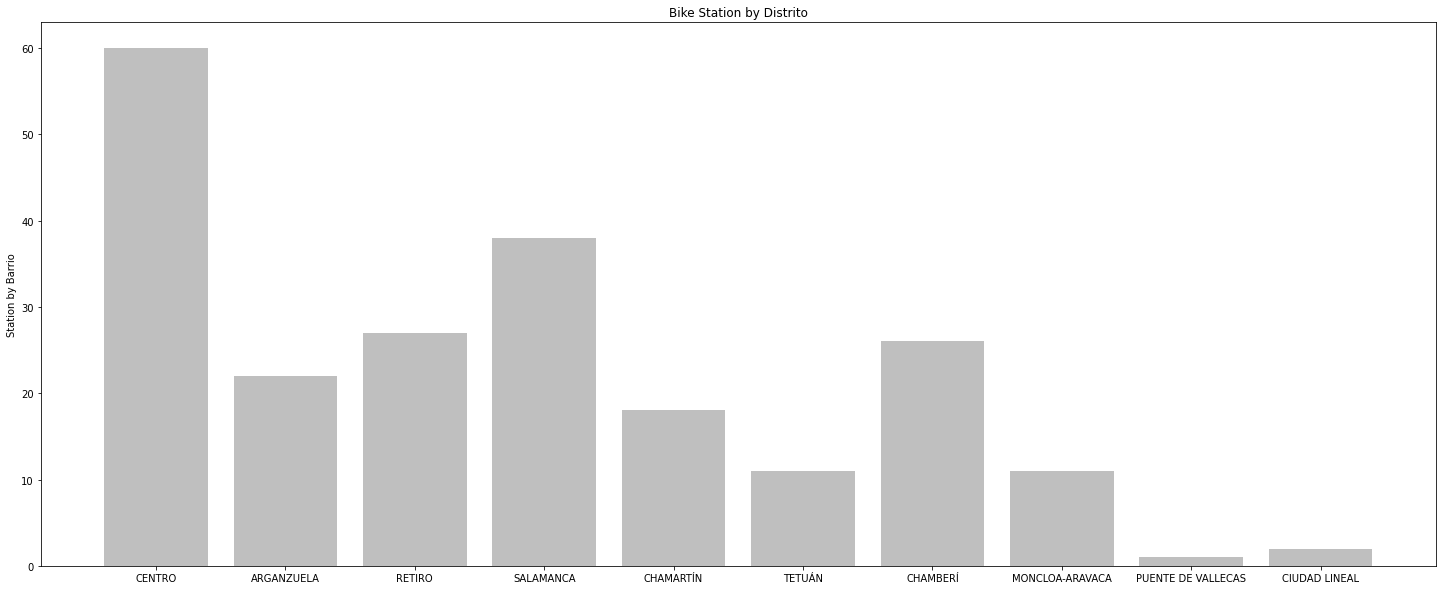

In [18]:
import matplotlib.pyplot as plt
# fig = plt.figure()
# fig.add_axes(langs)
langs = ['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTÍN', 'TETUÁN', 'CHAMBERÍ', 'MONCLOA-ARAVACA', 'PUENTE DE VALLECAS', 'CIUDAD LINEAL']
# ax.bar(langs,aa)
# plt.show()
fig=plt.figure()
fig.set_figheight(10)
fig.set_figwidth(25)
fig.set_facecolor('white')
y_pos = np.arange(len(langs))
plt.bar(y_pos, d_b, align='center', alpha=0.5, width=0.8, color = 'gray')
plt.xticks(y_pos, langs)
plt.ylabel('Station by Barrio')
plt.title('Bike Station by Distrito')

plt.show()

In [19]:
df.groupby('Distrito')['Anclajes'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)

count   sum       mean
Distrito                                      
01  CENTRO                 60  1419  23.650000
04  SALAMANCA              38   906  23.842105
03  RETIRO                 27   664  24.592593
07  CHAMBERÍ               26   584  22.461538
02  ARGANZUELA             22   541  24.590909
05  CHAMARTÍN              18   426  23.666667
06  TETUÁN                 11   258  23.454545
09  MONCLOA-ARAVACA        11   243  22.090909
15  CIUDAD LINEAL           2    51  25.500000
13  PUENTE DE VALLECAS      1    24  24.000000

#### Total Anclaje by Year

In [20]:
df.groupby('Year')['Anclajes'].agg(['sum'])

sum
Year      
2014  2872
2015   939
2016    24
2017    44
2018    15
2019  1147
2020    75

In [21]:
df['Anclajes'].sum()

5116

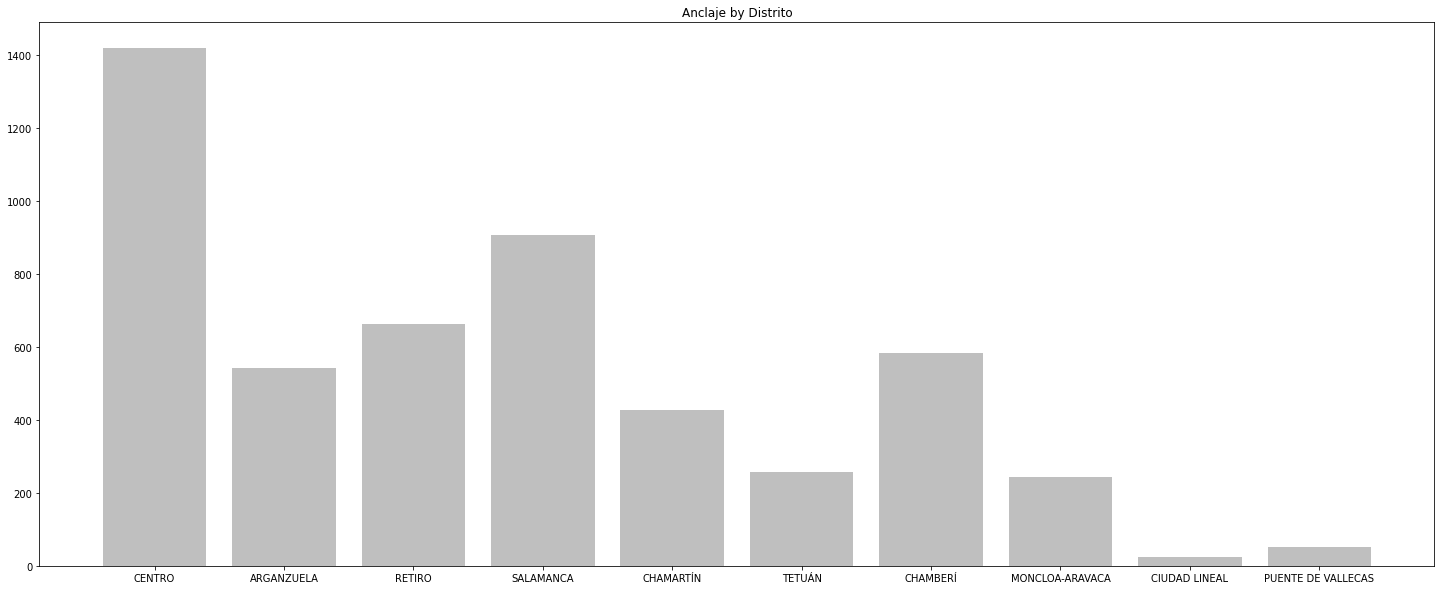

In [22]:
d_a = df.groupby('Distrito')['Anclajes'].sum()
langs = ['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTÍN', 'TETUÁN', 'CHAMBERÍ', 'MONCLOA-ARAVACA', 'CIUDAD LINEAL', 'PUENTE DE VALLECAS']
# ax.bar(langs,aa)
# plt.show()
fig=plt.figure()
fig.set_figheight(10)
fig.set_figwidth(25)
fig.set_facecolor('white')
y_pos = np.arange(len(langs))
plt.bar(y_pos, d_a, align='center', alpha=0.5, width=0.8, color = 'gray')
plt.xticks(y_pos, langs)
# plt.ylabel('Anclaje by Disti')
plt.title('Anclaje by Distrito')

plt.show()

In [149]:
df.columns

Index(['id', 'Gis_X', 'Gis_Y', 'Fecha de Alta', 'Distrito', 'Barrio', 'Calle',
       'Nº Finca', 'Tipo de Reserva', 'Anclajes', 'Unnamed: 10', 'LONGITUD',
       'LATITUD', 'DIRECCION', 'Year', 'ids', 'Locationlist', 'X', 'Y',
       'cluster1', 'cluster2'],
      dtype='object')

Text(0.5, 1.0, 'Total de Anclajes por Distrito y Año')

<Figure size 3600x10800 with 0 Axes>

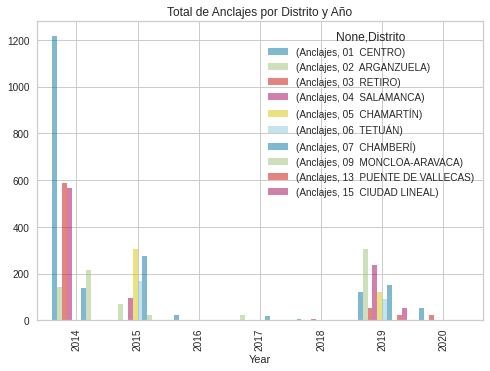

In [163]:
year_distrito = df.groupby(['Year','Distrito']).agg({'Anclajes': 'sum'})
fig1=plt.figure()
# rect = l,b,w,h
# fig1.add_axes(rect, frameon=False, axisbg='g')
# fig1.add_axes([2014, 2015, 2016, 2017, 2018, 2019, 2020])
# fig1.subplots_adjust(wspace=0.9, hspace=0.9)
fig1.set_figheight(150)
fig1.set_figwidth(50)
fig.set_facecolor('white')
# plt.bar(align='center', alpha=0.5, width=0.8, color = 'gray')

year_distrito.unstack().plot.bar(align='center', alpha=0.5, width=0.8)
plt.title("Total de Anclajes por Distrito y Año")


In [24]:
# plt.figure(figsize=[10,8])
# # x=d_a
# # x=d_b
# # n,bins,pat.hist([x,y])

# plt.hist([d_a,d_b])

In [25]:
d_e = df.groupby('id')['Distrito'].sum()
d_e

id
001 a                01  CENTRO
001 b                01  CENTRO
020 ampliacion       01  CENTRO
025 a                01  CENTRO
025 b                01  CENTRO
                      ...      
95                04  SALAMANCA
96                04  SALAMANCA
97                04  SALAMANCA
98                04  SALAMANCA
99                04  SALAMANCA
Name: Distrito, Length: 216, dtype: object

### Maps

  #### Get of coordinates (Longitude and Latitude)








In [26]:
locations = df[['LATITUD', 'LONGITUD']] # (Y, X)
locationlist = locations.values.tolist()
len(locationlist)
# locationlist 


216

In [27]:
df['Locationlist'] = locationlist

#### Scatterplot of X, Y

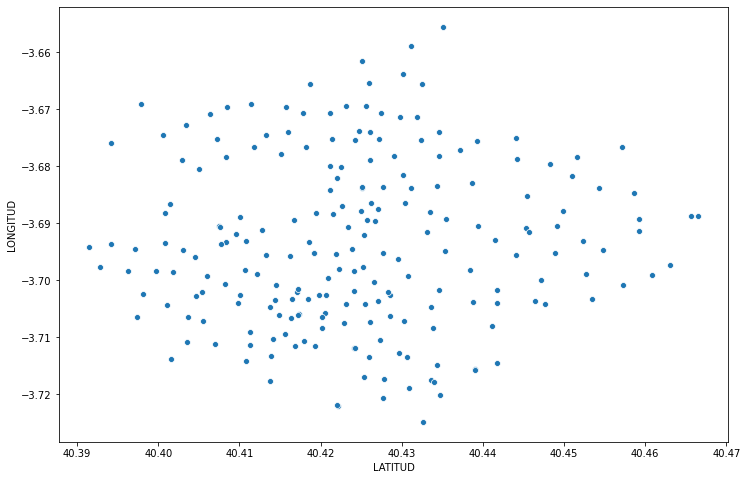

In [28]:
plt.figure(figsize = (12,8))
sns.scatterplot(df['LATITUD'], df['LONGITUD'])

#### Testing of map

In [29]:
import pandas as pd
import numpy as np
# import streamlit as st
import matplotlib.pyplot as plt
# import folium.plugins
# import plotly.express as px
from folium.plugins import MarkerCluster
# from bokeh.plotting import figure, output_file, show
# from streamlit_folium import folium_static

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/originalbikestations.csv", sep=';', encoding='utf-8')
df['Year'] = pd.DatetimeIndex(df['Fecha de Alta']).year
year = df['Year']
df = df.rename(columns = {'Número':'id','Número de Plazas':'Anclajes'}) #change de name of column Número
df['ids'] = df['id'].str.rstrip('ampliacionb') #to get only number values
# df_stations = df_stations[onlycolumns]
df['ids'] = df['ids'].astype(int).sort_values() #change values ids and order

d_b = df.groupby(['Distrito'])['Barrio'].count()

locations = df[['LATITUD', 'LONGITUD']] # (Y, X)
locationlist = locations.values.tolist()
df['Locationlist'] = locationlist

map1 = folium.Map(location=[40.417110795315295, -3.70199802576925], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['id'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='bicycle', angle=0, prefix='fa')).add_to(map1)
map1  

In [30]:
df.columns

Index(['id', 'Gis_X', 'Gis_Y', 'Fecha de Alta', 'Distrito', 'Barrio', 'Calle',
       'Nº Finca', 'Tipo de Reserva', 'Anclajes', 'Unnamed: 10', 'LONGITUD',
       'LATITUD', 'DIRECCION', 'Year', 'ids', 'Locationlist'],
      dtype='object')

#### Display of bike map in Madrid

In [31]:
map1 = folium.Map(location=[40.417110795315295, -3.70199802576925], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['id'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='bicycle', angle=0, prefix='fa')).add_to(map1)
map1  

#### Display of BikeMadrid per Distrito

In [32]:
import folium.plugins
folium.plugins.MarkerCluster()
map2 = folium.Map(location=[40.417110795315295, -3.70199802576925], tiles='Stamen Terrain', zoom_start=11)

marker_cluster = folium.plugins.MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['Distrito'][point], icon=folium.Icon(color='darkblue', icon_color='green', icon='bicycle', angle=0, prefix='fa')).add_to(marker_cluster)
map2

In [33]:
import plotly.express as px
fig = px.scatter_geo(df, locations=df['Locationlist'], locationmode='country names', color= df['Distrito'].sort_values(), hover_name=df['Calle'],
                     size=df['Anclajes'], scope='europe', 
                     animation_frame=df['Year'].sort_values(), 
                     projection='stereographic')
# (df, locations="Locationlist", hover_name="Distrito", animation_frame="Year", projection="natural earth")
fig.show()

### Machine Learning 

#### Transformation is to convert the latitude and longitude to radians instead of degrees

In [34]:
import numpy as np
df["X"] = np.radians(df["LONGITUD"]) # add new columns with transformation to radians
X = df['X']
df["Y"] = np.radians(df["LATITUD"])
Y = df['Y']

#### Unsupervised Model using AgglomerativeClustering

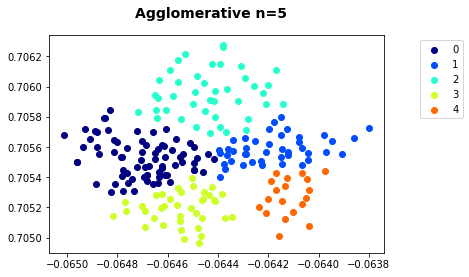

In [35]:
from sklearn import cluster
df["X"] = np.radians(df["LONGITUD"]) # add new columns with transformation to radians
X = df['X']
df["Y"] = np.radians(df["LATITUD"])
Y = df['Y']

data = df[["X", "Y"]]

hclust1 = cluster.AgglomerativeClustering(n_clusters=5)
label = hclust1.fit_predict(data)
df['cluster1'] = label

fig = plt.figure()
fig.suptitle('Agglomerative n=5', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)

clusters = list(set(label))

for i in range(len(clusters)):
  plt.scatter(df[df.cluster1 == clusters[i]].X, df[df.cluster1 == clusters[i]].Y, 
                label=i, color=plt.cm.jet(np.float(i) / len(np.unique(label))))

plt.legend(bbox_to_anchor=(1.25, 1))

In [36]:
df.head()

id      Gis_X       Gis_Y  ...         X         Y cluster1
0  001 a  440443,61  4474290,65  ... -0.064612  0.705412        0
1  001 b  440480,56  4474301,74  ... -0.064604  0.705413        0
2      2  440134,83  4474678,23  ... -0.064676  0.705472        0
3      3  440012,98  4475760,68  ... -0.064703  0.705642        0
4      4   440396,4  4475565,36  ... -0.064624  0.705612        0

[5 rows x 20 columns]

In [37]:
cluster1 = np.sum(np.square(np.linalg.norm(data.shape - centroids[clusters], axis=1)))
cluster1

NameError: ignored

#### Unsupervised Model using KMeans Clustering

In [38]:
kmeans=cluster.KMeans(n_clusters=5)
kcluster = kmeans.fit_predict(data)

df['cluster2'] = kcluster

In [39]:
centroids2 = kmeans.cluster_centers_
centroids2

array([[-0.06412724,  0.70525621],
       [-0.06472402,  0.70556766],
       [-0.06444156,  0.70599497],
       [-0.06420349,  0.70560339],
       [-0.06456784,  0.70524561]])

In [40]:
cluster2 = np.sum(np.square(np.linalg.norm(data.shape - centroids2[clusters], axis=1)))
cluster2

233427.53067483433

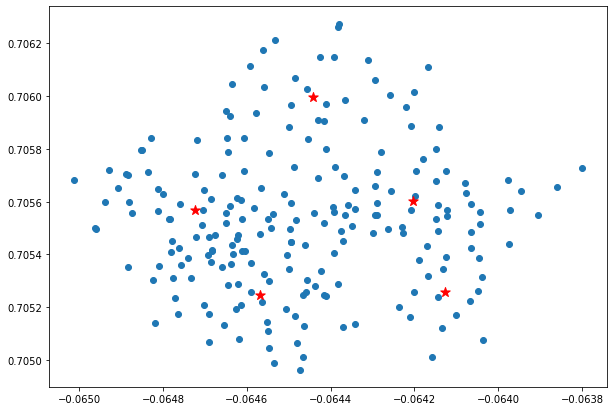

In [41]:
K = 5
figure = plt.figure(figsize=(10,7))
plt.scatter(X, Y, cmap="plasma", linewidths=1);
for k in range(K):
  plt.scatter(centroids2[k,0], centroids2[k, 1], s=100, marker='*', color='red')

plt.show()

In [42]:
sse2 = kmeans.inertia_
sse2

6.784752230089113e-06

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



AttributeError: ignored

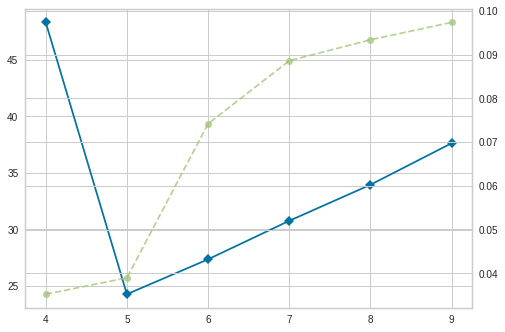

In [43]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

# Generate synthetic dataset with 5 random clusters
X, y = make_blobs(n_samples=1000, n_features=5, centers=5, random_state=42)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()  

#### Metrics: Sum of Square Error

In [44]:
sse = kmeans.inertia_
sse

6.784752230089113e-06

In [45]:
# data = df['pickup cluster']
# # Sum of Squared Error

# # np.sum(np.square(np.linalg.norm(df['pickup cluster'] - centroids[clusters], axis=1)))
# def sse(data, clusters, centroids):
#     return np.sum(np.square(np.linalg.norm(data - centroids[clusters], axis=1))) 

# ks = range(2, 20)
# sse_errors = np.zeros(len(ks))

# for i, k in enumerate(ks):
#     # clusters_, centroids_ = kmeans(df['pickup cluster'], k)
#     sse_errors[i] = sse(df['pickup cluster'], clusters, centroids)
#     print(k, sse_errors[i])

### Only Stations 2019

In [46]:
stations_2019 = df[df['Year'] <= 2019] #save the 2019 stations data for use to jan18
stations_2019['idunplug_station'] = stations_2019['ids']
stations_2019['idplug_station'] = stations_2019['ids']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
stations_2019.head()

# Exploration and cleaning Jan18 Dataset

####Load of Libraries

In [47]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 

####Acquiring data

In [48]:
downloaded = drive.CreateFile({'id':'1dBJtPkHMvyF5Pmeu-w8z-Y91smROB_6b'})
downloaded.GetContentFile('jan18.json')
# downloaded.GetContentFile('jan18_clean.json')

In [49]:
print(os.getcwd)

<built-in function getcwd>


#### Reading and Exploring data

In [50]:
jan18 = pd.read_json("jan18.json",encoding="utf-8", lines=True, dtype='frame')# open de file

In [51]:
jan18.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263702 entries, 0 to 263701
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   _id               263702 non-null  object
 1   user_day_code     263702 non-null  object
 2   idplug_base       263702 non-null  int64 
 3   user_type         263702 non-null  int64 
 4   idunplug_base     263702 non-null  int64 
 5   travel_time       263702 non-null  int64 
 6   idunplug_station  263702 non-null  int64 
 7   ageRange          263702 non-null  int64 
 8   idplug_station    263702 non-null  int64 
 9   unplug_hourTime   263702 non-null  object
 10  zip_code          263702 non-null  object
dtypes: int64(7), object(4)
memory usage: 22.1+ MB


In [52]:
# Save of position in _id column 
position = dict(enumerate(jan18['_id'].values))
position
type(position)
ids = []
# Save of values in its position 
ids = []
for d, v in position.items():
    ids += list(v.values())
#Save in the column _id
jan18['_id'] = ids 

In [53]:
na_columns = ['_id', 'user_day_code', 'idunplug_station', 'idunplug_base', 'idplug_station', 'idplug_base',
   'user_type','travel_time','unplug_hourTime', 'ageRange', 'zip_code']
jan18 = jan18[na_columns]
jan18 = jan18.rename(columns = {'_id':'id'})

# jan18.columns = ['_id', 'user_day_code', 'idunplug_base','idunplug_station','idplug_base', 'idplug_station',
#        'user_type','travel_time','unplug_hourTime', 'ageRange', 'zip_code']

In [54]:
# jan18.to_csv('jan18_clean.csv') # to save the dataset

In [55]:
jan18.head(1000)

id  ... zip_code
0    5a505acd2f384319304ed614  ...    28010
1    5a505acd2f384319304ed615  ...         
2    5a505acd2f384319304ed616  ...         
3    5a505acd2f384319304ed617  ...    28005
4    5a505acd2f384319304ed619  ...    28004
..                        ...  ...      ...
995  5a505ad12f384319304eda71  ...    28003
996  5a505ad12f384319304eda73  ...    28009
997  5a505ad12f384319304eda72  ...         
998  5a505ad12f384319304eda74  ...    28001
999  5a505ad12f384319304eda75  ...    28007

[1000 rows x 11 columns]

In [56]:
# jan18[jan18['idplug_station'] == 2008] #show the result

In [57]:
jan18 = jan18.drop(jan18[jan18.idplug_station == 2008].index) #deleting values 2008

In [58]:
jan18.isna().sum()

id                  0
user_day_code       0
idunplug_station    0
idunplug_base       0
idplug_station      0
idplug_base         0
user_type           0
travel_time         0
unplug_hourTime     0
ageRange            0
zip_code            0
dtype: int64

In [59]:
# About null 
jan18.isnull().sum()

id                  0
user_day_code       0
idunplug_station    0
idunplug_base       0
idplug_station      0
idplug_base         0
user_type           0
travel_time         0
unplug_hourTime     0
ageRange            0
zip_code            0
dtype: int64

# Unification processing Dataset (Jan18 and Stations_2019)

####Proceso Unificado

In [60]:
new_dataset = pd.merge(jan18, stations_2019, on='idunplug_station')
new_dataset = new_dataset.rename(columns={'Gis_X':'Gis_Xidunplug',
       'Gis_Y':'Gis_Yidunplug', 'Fecha de Alta':'Fecha de Alta_idunplug', 'Distrito':'Distrito_idunplug', 'Barrio':'Barrio_idunplug', 'Calle':'Calle_idunplug', 'Nº Finca':'Nº Finca_idunplug',
        'Anclajes':'Anclajes_idunplug', 'Longitud':'Longitud_idunplug', 'Latitud':'Latitud_idunplug', 'DIRECCION':'DIRECCION_idunplug',
       'Year':'Year_idunplug', 'Locationlist':'Locationlist_idunplug', 'X':'X_idunplug', 'Y':'Y_idunplug'}) #change de name of the columns

del new_dataset['ids']
another_dataset = pd.merge(jan18,stations_2019, on = 'idplug_station')

another_dataset = another_dataset.rename(columns={'Gis_X':'Gis_Xidplug',
       'Gis_Y':'Gis_Yidplug', 'Fecha de Alta':'Fecha de Alta_idplug', 'Distrito':'Distrito_idplug', 'Barrio':'Barrio_idplug', 'Calle':'Calle_idplug', 'Nº Finca':'Nº Finca_idplug',
        'Anclajes':'Anclajes_idplug', 'Longitud':'Longitud_idplug', 'Latitud':'Latitud_idplug', 'DIRECCION':'DIRECCION_idplug',
       'Year':'Year_idplug', 'Locationlist':'Locationlist_idplug', 'X':'X_idplug', 'Y':'Y_idplug'})
del another_dataset['ids']

another_dataset.to_csv("another_dataset")
new_dataset.to_csv("new_dataset")# to save
new_dataset = pd.merge(jan18, stations_2019, on='idunplug_station') #join jan18 and stations_2019 using idunplug_station

join_data = pd.merge(new_dataset, another_dataset, on=['user_day_code'])

In [61]:
# another_dataset = pd.merge(jan18,stations_2019, on = 'idplug_station', indicator=True, how='left') #que tipo de merge hace en cada fila 
another_dataset.head(2)

id_x  ... idunplug_station_y
0  5a505acd2f384319304ed614  ...                  7
1  5a505acf2f384319304ed839  ...                  7

[2 rows x 32 columns]

#### Paso a paso

In [62]:
new_dataset = pd.merge(jan18, stations_2019, on='idunplug_station') #join jan18 and stations_2019 using idunplug_station

In [63]:
new_dataset.columns #get the columns

Index(['id_x', 'user_day_code', 'idunplug_station', 'idunplug_base',
       'idplug_station_x', 'idplug_base', 'user_type', 'travel_time',
       'unplug_hourTime', 'ageRange', 'zip_code', 'id_y', 'Gis_X', 'Gis_Y',
       'Fecha de Alta', 'Distrito', 'Barrio', 'Calle', 'Nº Finca',
       'Tipo de Reserva', 'Anclajes', 'Unnamed: 10', 'LONGITUD', 'LATITUD',
       'DIRECCION', 'Year', 'ids', 'Locationlist', 'X', 'Y', 'cluster1',
       'cluster2', 'idplug_station_y'],
      dtype='object')

In [64]:
new_dataset = new_dataset.rename(columns={'Gis_X':'Gis_Xidunplug',
       'Gis_Y':'Gis_Yidunplug', 'Fecha de Alta':'Fecha de Alta_idunplug', 'Distrito':'Distrito_idunplug', 'Barrio':'Barrio_idunplug', 'Calle':'Calle_idunplug', 'Nº Finca':'Nº Finca_idunplug',
        'Anclajes':'Anclajes_idunplug', 'Longitud':'Longitud_idunplug', 'Latitud':'Latitud_idunplug', 'DIRECCION':'DIRECCION_idunplug',
       'Year':'Year_idunplug', 'Locationlist':'Locationlist_idunplug', 'X':'X_idunplug', 'Y':'Y_idunplug'}) #change de name of the columns

del new_dataset['ids']

In [65]:
new_dataset.head(1) #show first values

id_x  ... idplug_station_y
0  5a505acd2f384319304ed614  ...                6

[1 rows x 32 columns]

In [66]:
another_dataset = pd.merge(jan18,stations_2019, on = 'idplug_station') # join jan18 and stations_2019 by idplug_station

In [67]:
another_dataset = another_dataset.rename(columns={'Gis_X':'Gis_Xidplug',
       'Gis_Y':'Gis_Yidplug', 'Fecha de Alta':'Fecha de Alta_idplug', 'Distrito':'Distrito_idplug', 'Barrio':'Barrio_idplug', 'Calle':'Calle_idplug', 'Nº Finca':'Nº Finca_idplug',
        'Anclajes':'Anclajes_idplug', 'Longitud':'Longitud_idplug', 'Latitud':'Latitud_idplug', 'DIRECCION':'DIRECCION_idplug',
       'Year':'Year_idplug', 'Locationlist':'Locationlist_idplug', 'X':'X_idplug', 'Y':'Y_idplug'}) #change the name of columns

In [68]:
del another_dataset['ids']
another_dataset.head(5) #show the first five values

id_x  ... idunplug_station_y
0  5a505acd2f384319304ed614  ...                  7
1  5a505acf2f384319304ed839  ...                  7
2  5a505ad02f384319304ed944  ...                  7
3  5a505ad52f384319304edde2  ...                  7
4  5a505ad72f384319304edf6b  ...                  7

[5 rows x 32 columns]

In [69]:
another_dataset.to_csv("another_dataset")#to save 

In [70]:
another_dataset.to_csv("another_dataset")
new_dataset.to_csv("new_dataset")# to save

In [71]:
join_data = pd.merge(new_dataset, another_dataset, on=['user_day_code']) #IT'S WORK!

In [72]:
join_data.columns

Index(['id_x_x', 'user_day_code', 'idunplug_station', 'idunplug_base_x',
       'idplug_station_x', 'idplug_base_x', 'user_type_x', 'travel_time_x',
       'unplug_hourTime_x', 'ageRange_x', 'zip_code_x', 'id_y_x',
       'Gis_Xidunplug', 'Gis_Yidunplug', 'Fecha de Alta_idunplug',
       'Distrito_idunplug', 'Barrio_idunplug', 'Calle_idunplug',
       'Nº Finca_idunplug', 'Tipo de Reserva_x', 'Anclajes_idunplug',
       'Unnamed: 10_x', 'LONGITUD_x', 'LATITUD_x', 'DIRECCION_idunplug',
       'Year_idunplug', 'Locationlist_idunplug', 'X_idunplug', 'Y_idunplug',
       'cluster1_x', 'cluster2_x', 'idplug_station_y', 'id_x_y',
       'idunplug_station_x', 'idunplug_base_y', 'idplug_station',
       'idplug_base_y', 'user_type_y', 'travel_time_y', 'unplug_hourTime_y',
       'ageRange_y', 'zip_code_y', 'id_y_y', 'Gis_Xidplug', 'Gis_Yidplug',
       'Fecha de Alta_idplug', 'Distrito_idplug', 'Barrio_idplug',
       'Calle_idplug', 'Nº Finca_idplug', 'Tipo de Reserva_y',
       'Anclajes_idp

In [73]:
join_data.head(5)

id_x_x  ... idunplug_station_y
0  5a505acd2f384319304ed614  ...                  7
1  5a505ad02f384319304ed925  ...                 67
2  5a505ad02f384319304ed925  ...                 65
3  5a505adb2f384319304ee2dd  ...                 67
4  5a505adb2f384319304ee2dd  ...                 65

[5 rows x 63 columns]

In [74]:
this_columns = ['id_x_x', 'user_day_code', 'idunplug_station', 'Distrito_idunplug', 'Barrio_idunplug','Longitud_idunplug', 'Latitud_idunplug', 
              'idplug_station_x', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug', 'Latitud_idplug',
               'user_type_x', 'travel_time_x','unplug_hourTime_x', 'ageRange_x', 'zip_code_x' ]

In [75]:
join_data.columns

Index(['id_x_x', 'user_day_code', 'idunplug_station', 'idunplug_base_x',
       'idplug_station_x', 'idplug_base_x', 'user_type_x', 'travel_time_x',
       'unplug_hourTime_x', 'ageRange_x', 'zip_code_x', 'id_y_x',
       'Gis_Xidunplug', 'Gis_Yidunplug', 'Fecha de Alta_idunplug',
       'Distrito_idunplug', 'Barrio_idunplug', 'Calle_idunplug',
       'Nº Finca_idunplug', 'Tipo de Reserva_x', 'Anclajes_idunplug',
       'Unnamed: 10_x', 'LONGITUD_x', 'LATITUD_x', 'DIRECCION_idunplug',
       'Year_idunplug', 'Locationlist_idunplug', 'X_idunplug', 'Y_idunplug',
       'cluster1_x', 'cluster2_x', 'idplug_station_y', 'id_x_y',
       'idunplug_station_x', 'idunplug_base_y', 'idplug_station',
       'idplug_base_y', 'user_type_y', 'travel_time_y', 'unplug_hourTime_y',
       'ageRange_y', 'zip_code_y', 'id_y_y', 'Gis_Xidplug', 'Gis_Yidplug',
       'Fecha de Alta_idplug', 'Distrito_idplug', 'Barrio_idplug',
       'Calle_idplug', 'Nº Finca_idplug', 'Tipo de Reserva_y',
       'Anclajes_idp

In [76]:
join_data = join_data[this_columns]
join_data.head(5)

KeyError: ignored

In [ ]:
join_data.to_json("join_data")

#**Exploration unified data of Jan18 and Stations 2019**

In [77]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn 

### Acquiring data

In [78]:
data = pd.read_json("/content/drive/My Drive/Colab Notebooks/data/join_data", encoding="utf-8", dtype="frame")

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2926629 entries, 0 to 2926628
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id_x_x             object 
 1   user_day_code      object 
 2   idunplug_station   int64  
 3   Distrito_idunplug  object 
 4   Barrio_idunplug    object 
 5   Longitud_idunplug  float64
 6   Latitud_idunplug   float64
 7   idplug_station_x   int64  
 8   Distrito_idplug    object 
 9   Barrio_idplug      object 
 10  Longitud_idplug    float64
 11  Latitud_idplug     float64
 12  user_type_x        int64  
 13  travel_time_x      int64  
 14  unplug_hourTime_x  object 
 15  ageRange_x         int64  
 16  zip_code_x         object 
dtypes: float64(4), int64(5), object(8)
memory usage: 401.9+ MB


In [80]:
missing_values_count = data.isnull().sum()
missing_values_count

id_x_x               0
user_day_code        0
idunplug_station     0
Distrito_idunplug    0
Barrio_idunplug      0
Longitud_idunplug    0
Latitud_idunplug     0
idplug_station_x     0
Distrito_idplug      0
Barrio_idplug        0
Longitud_idplug      0
Latitud_idplug       0
user_type_x          0
travel_time_x        0
unplug_hourTime_x    0
ageRange_x           0
zip_code_x           0
dtype: int64

In [81]:
# Cleaning columns 
# data.columns
data = data.rename(columns={'id_x_x': '_id','idplug_station_x':'idplug_station',
       'user_type_x':'user_type', 'travel_time_x':'travel_time',
       'unplug_hourTime_x':'unplug_hourTime', 'ageRange_x':'ageRange', 'zip_code_x':'zip_code'})

In [82]:
data.head()

_id  ... zip_code
0  5a505acd2f384319304ed614  ...    28010
1  5a505ad02f384319304ed925  ...    28007
2  5a505ad02f384319304ed925  ...    28007
3  5a505adb2f384319304ee2dd  ...    28007
4  5a505adb2f384319304ee2dd  ...    28007

[5 rows x 17 columns]

In [203]:
data['_id'].value_count()

AttributeError: ignored

In [188]:
data[data['_id'] == '5a505acd2f384319304ed614']

_id  ... zip_code
0  5a505acd2f384319304ed614  ...    28010

[1 rows x 17 columns]

### User_day_code by age

In [83]:
data.groupby('user_day_code')['ageRange'].value_counts().describe()

count    140719.000000
mean         20.797682
std         454.710082
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max       38416.000000
Name: ageRange, dtype: float64

#### Histogram of AgeRange by User_day_code

(array([ 255858.,  709123.,       0.,    9080.,       0.,  180968.,
        1165861.,       0.,  602722.,    3017.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

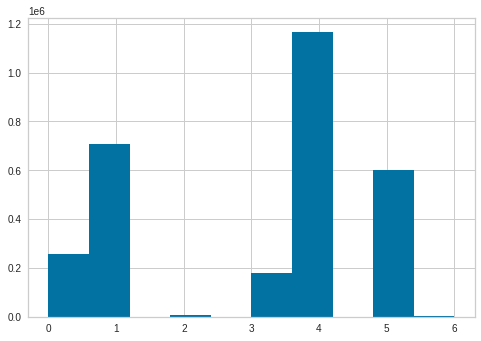

In [84]:
plt.hist(data['ageRange'])

#### Display plot of AgeRange by User_day_code

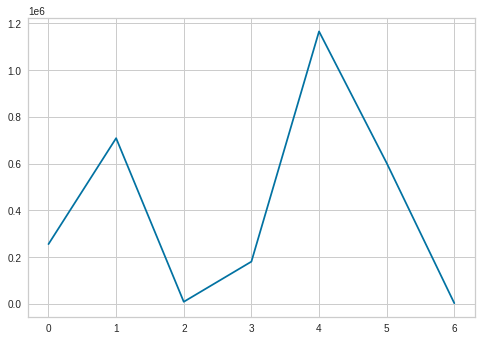

In [172]:
plt.plot(data.groupby('ageRange')['user_day_code'].count())

**AgeRange:**

0: No se ha podido determinar el rango de edad del usuario

*1: El usuario tiene entre 0 y 16 años*

2: El usuario tiene entre 17 y 18 años

3: El usuario tiene entre 19 y 26 años

*4: El usuario tiene entre 27 y 40 años*

*5: El usuario tiene entre 41 y 65 años*

6: El usuario tiene 66 años o más 


En el Mes de Enero 2018, los usuarios que más utilizando la bici son:

1. El usuario tiene entre 27 y 40 años
2. El usuario tiene entre 17 y 18 años
3. El usuario tiene entre 41 y 65 años

### Desenganche de bici por edad

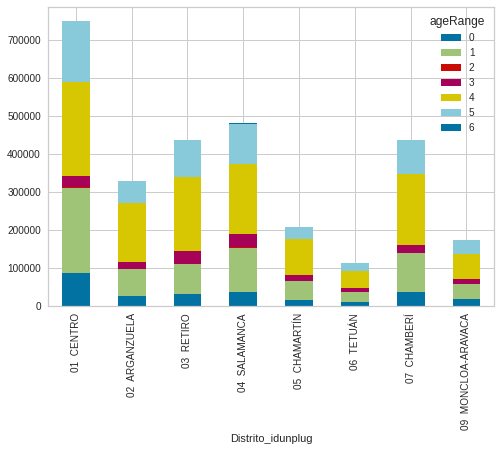

In [117]:
data.groupby(['Distrito_idunplug', 'ageRange']).size().unstack().plot(kind='bar', stacked=True)

### Enganche de Bici por Edad

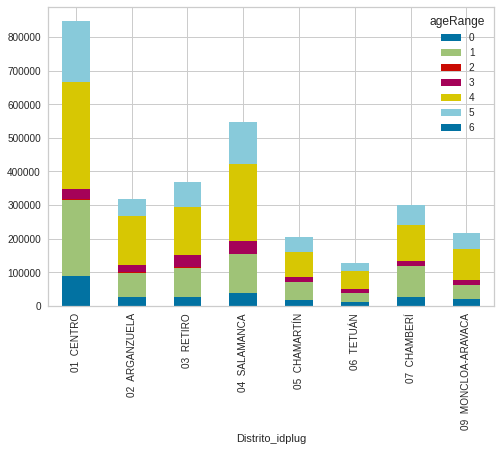

In [116]:
data.groupby(['Distrito_idplug','ageRange']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

<Figure size 720x360 with 0 Axes>

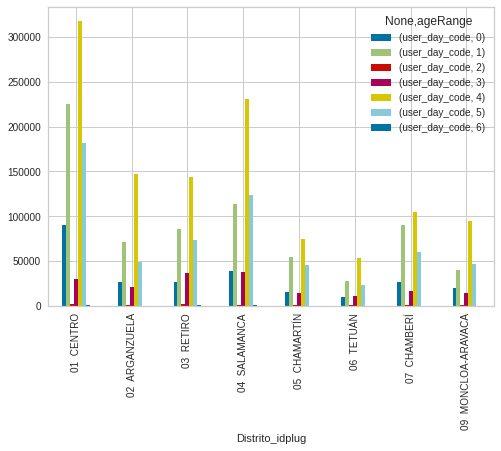

In [113]:
indpl_age = data.groupby(['Distrito_idplug', 'ageRange']).agg({'user_day_code': 'count'})
fig2 = plt.figure()
fig2.set_figheight(5)
fig2.set_figwidth(10)
indun_age.unstack().plot.bar()

### En que Distrito desengancha y en cual se engancha



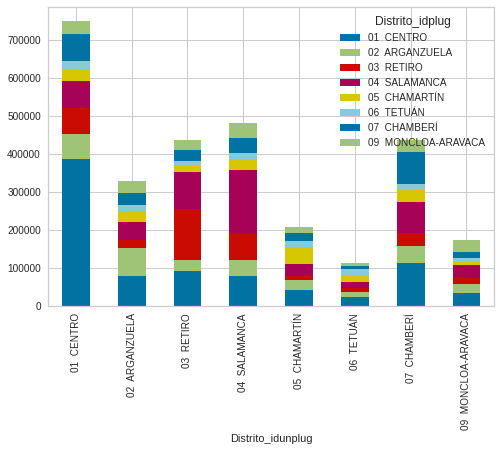

<Figure size 10800x1800 with 0 Axes>

In [138]:
data.groupby(['Distrito_idunplug', 'Distrito_idplug']).size().unstack().plot(kind='bar', stacked=True)
fig3 = plt.figure()
fig3.set_figheight(25)
fig3.set_figwidth(150)
plt.show()

In [142]:
dese_eng = pd.DataFrame(data.groupby(['Distrito_idunplug', 'Distrito_idplug']).size())
dese_eng

0
Distrito_idunplug   Distrito_idplug            
01  CENTRO          01  CENTRO           386583
                    02  ARGANZUELA        65985
                    03  RETIRO            67967
                    04  SALAMANCA         71393
                    05  CHAMARTÍN         30474
...                                         ...
09  MONCLOA-ARAVACA 04  SALAMANCA         34915
                    05  CHAMARTÍN         10362
                    06  TETUÁN             7396
                    07  CHAMBERÍ          15167
                    09  MONCLOA-ARAVACA   32407

[64 rows x 1 columns]

### Enero 19

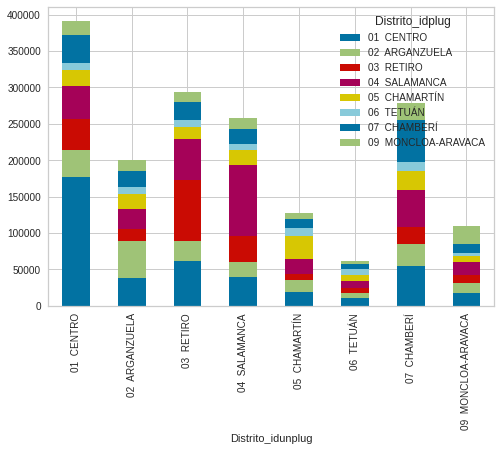

<Figure size 10800x1800 with 0 Axes>

In [181]:
data19.groupby(['Distrito_idunplug', 'Distrito_idplug']).size().unstack().plot(kind='bar', stacked=True)
fig3 = plt.figure()
fig3.set_figheight(25)
fig3.set_figwidth(150)
plt.show()

In [185]:
dese_eng19 = pd.DataFrame(data19.groupby(['Distrito_idunplug', 'Distrito_idplug']).size())
dese_eng19

0
Distrito_idunplug   Distrito_idplug            
01  CENTRO          01  CENTRO           176457
                    02  ARGANZUELA        37098
                    03  RETIRO            42801
                    04  SALAMANCA         45361
                    05  CHAMARTÍN         21614
...                                         ...
09  MONCLOA-ARAVACA 04  SALAMANCA         18045
                    05  CHAMARTÍN          7627
                    06  TETUÁN             3907
                    07  CHAMBERÍ          13316
                    09  MONCLOA-ARAVACA   23482

[64 rows x 1 columns]

###Manipulating data with time variable

In [ ]:
data['travel_minutes'] = data['travel_time'] / 60
data['travel_minutes']

0           4.733333
1          13.733333
2          13.733333
3           5.616667
4           5.616667
             ...    
2926624     5.216667
2926625     3.750000
2926626    11.400000
2926627     2.683333
2926628     2.900000
Name: travel_minutes, Length: 2926629, dtype: float64

In [ ]:
data['travel_minutes'].describe()

count    2.926629e+06
mean     2.963612e+01
std      2.524467e+02
min      1.666667e-02
25%      1.666667e-01
50%      9.933333e+00
75%      3.196667e+01
max      2.752708e+04
Name: travel_minutes, dtype: float64

#### Statistcs of User type by travel minutes.

In [ ]:
data.groupby('user_type')['travel_minutes'].describe()

count       mean         std  ...        50%        75%           max
user_type                                    ...                                    
1           534546.0  15.790231   20.775760  ...  10.750000  16.066667    359.716667
2             6324.0  36.316543   36.901316  ...  22.858333  48.633333    327.383333
3          2385759.0  32.720677  279.328389  ...   6.216667  36.833333  27527.083333

[3 rows x 8 columns]

#### Grouping by possible type of trip

In [ ]:
travel_35 = data[(data['travel_minutes'] >= 15) & (data['travel_minutes'] <= 35)] # Funtional
travel_180 = data[(data['travel_minutes'] >= 35) & (data['travel_minutes'] <= 180)] # Recreative
travel_190 = data[data['travel_minutes'] >=181] # BreakDown

#### Travel Minutes Plotting

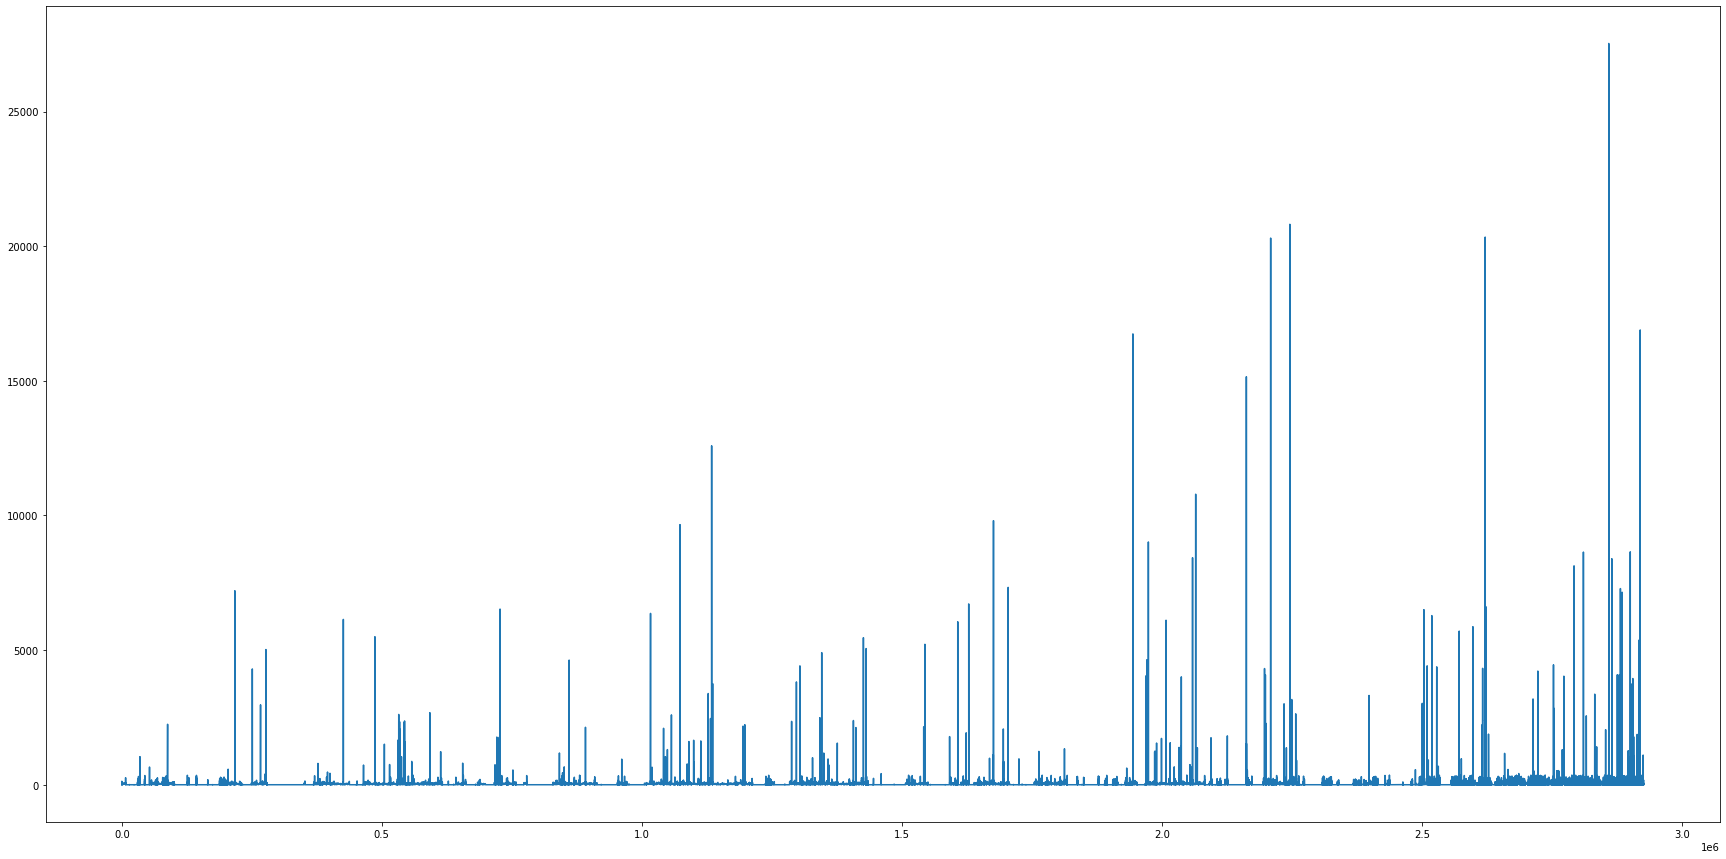

In [ ]:
 data['travel_minutes'].plot(figsize=(30, 15))

### Trip of a specific user

In [ ]:
data['user_day_code'][0]

'b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64644821b72d560b100f'

In [ ]:
data[data['user_day_code'] == 'b00665a845be18ed9f036c2d72def1ef2fa2c49365cb64644821b72d560b100f']

_id  ... travel_minutes
0  5a505acd2f384319304ed614  ...       4.733333

[1 rows x 18 columns]

In [ ]:
data['idunplug_station'].sort_values().count()

2926629

In [ ]:
# aa = jan18[(jan18.idunplug_station == '1') & (jan18.idplug_station == '2')].index() #don't work

#### Display the tweenty user that most use the bike in January 18 month.

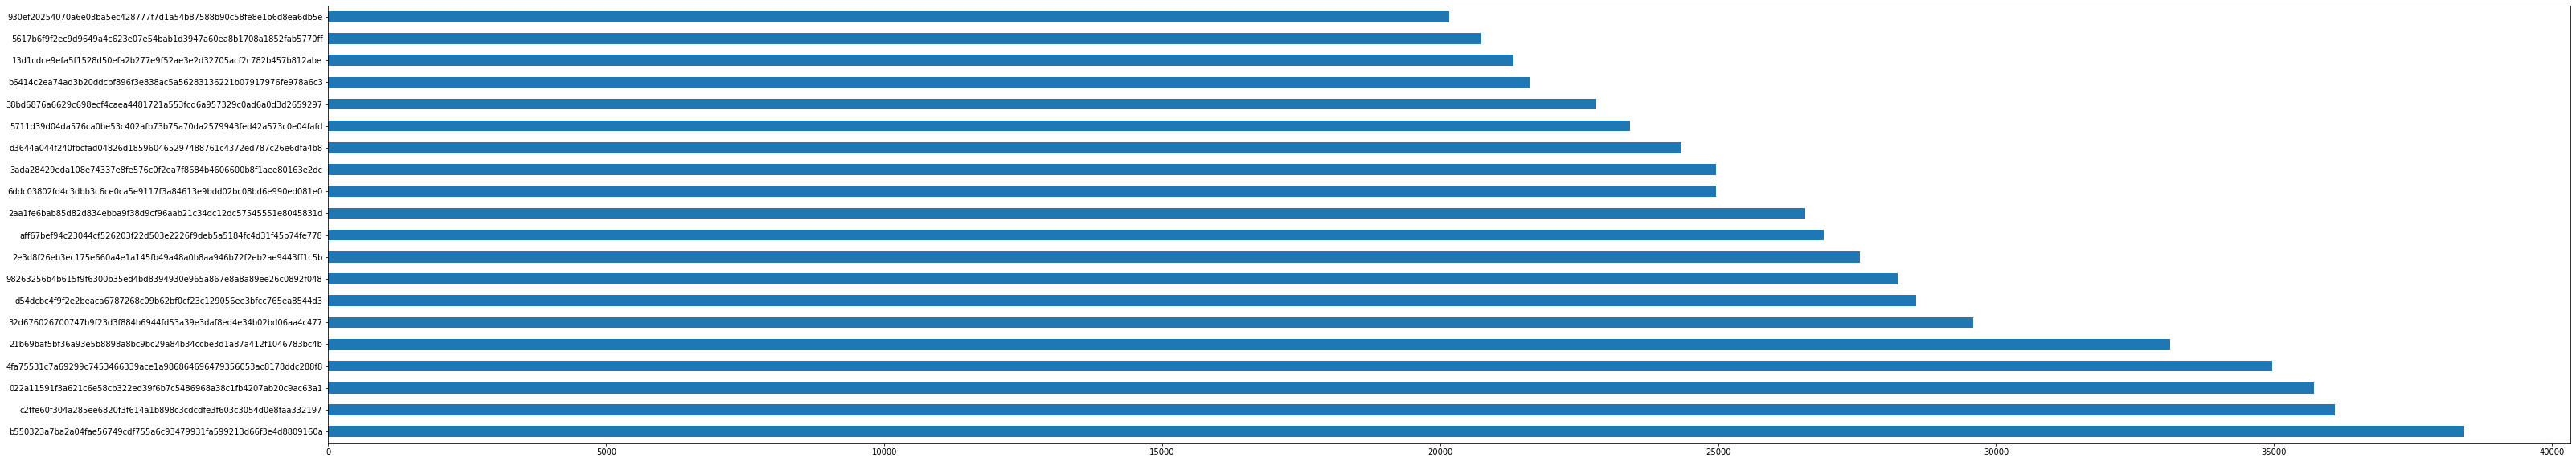

In [ ]:
mostfreque_user = data['user_day_code'].value_counts(sort=True).head(20)

fig = plt.figure(figsize=(50,10))
mostfreque_user.plot.barh()


In [ ]:
data['user_day_code'].value_counts(sort=True).head(1000)

b550323a7ba2a04fae56749cdf755a6c93479931fa599213d66f3e4d8809160a    38416
c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197    36100
022a11591f3a621c6e58cb322ed39f6b7c5486968a38c1fb4207ab20c9ac63a1    35721
4fa75531c7a69299c7453466339ace1a986864696479356053ac8178ddc288f8    34969
21b69baf5bf36a93e5b8898a8bc9bc29a84b34ccbe3d1a87a412f1046783bc4b    33124
                                                                    ...  
76820452f1c8f232fa14e617370e3aa3aa06392a4557e8938b3f91378b71ff45       36
edac47afa328280a3c8bd4f4ac134036bce0142d1827005fcd18525b9d4b2d94       36
d999bbd430d5d7b4f62fb5ef384aeb1dac64934974fe1062a46257fae73299fe       36
8b6790f6461b527590d99b0acf7634a4fc10e62b2200241b791c6c48ab5652a8       36
affff68b248f587a04ce4600016548a87bcdc698c3e671b318e83465cef93c60       36
Name: user_day_code, Length: 1000, dtype: int64

In [ ]:
data[data['user_day_code'] == 'c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197'] #example one person all his travel

_id  ... travel_minutes
314362  5a569d852f384338109b9644  ...       0.633333
314363  5a569d852f384338109b9644  ...       0.633333
314364  5a569d852f384338109b9644  ...       0.633333
314365  5a569d852f384338109b9644  ...       0.633333
314366  5a569d852f384338109b9644  ...       0.633333
...                          ...  ...            ...
350457  5a569d872f384338109b97a9  ...       0.166667
350458  5a569d872f384338109b97a9  ...       0.166667
350459  5a569d872f384338109b97a9  ...       0.166667
350460  5a569d872f384338109b97a9  ...       0.166667
350461  5a569d872f384338109b97a9  ...       0.166667

[36100 rows x 18 columns]

In [ ]:
station = pd.DataFrame(data['idunplug_station'], data['idplug_station']) #create a new dataframe

In [ ]:
data['idunplug_station'].value_counts

<bound method IndexOpsMixin.value_counts of 0            6
1            6
2            6
3          104
4          104
          ... 
2926624     29
2926625     29
2926626     29
2926627     29
2926628     29
Name: idunplug_station, Length: 2926629, dtype: int64>

In [ ]:
data['idunplug_station'].value_counts() # count values of idunplug_station 

128    67652
129    66468
135    66081
132    56105
43     51662
       ...  
173     6358
123     6164
5       5981
124     5838
29      3138
Name: idunplug_station, Length: 166, dtype: int64

In [ ]:
data['idunplug_station'].value_counts(normalize=True, sort=True) #relative frequence

128    0.023116
129    0.022711
135    0.022579
132    0.019171
43     0.017652
         ...   
173    0.002172
123    0.002106
5      0.002044
124    0.001995
29     0.001072
Name: idunplug_station, Length: 166, dtype: float64

In [ ]:
# Know the set in idunplug_station 
# set(jan18['idunplug_station'])

### Rank for user day variable

In [ ]:
user_rank = data['user_day_code'].value_counts()
user_rank

b550323a7ba2a04fae56749cdf755a6c93479931fa599213d66f3e4d8809160a    38416
c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197    36100
022a11591f3a621c6e58cb322ed39f6b7c5486968a38c1fb4207ab20c9ac63a1    35721
4fa75531c7a69299c7453466339ace1a986864696479356053ac8178ddc288f8    34969
21b69baf5bf36a93e5b8898a8bc9bc29a84b34ccbe3d1a87a412f1046783bc4b    33124
                                                                    ...  
c1e667abe01c3c0c4410fb9269d4868a820f517ac6f96eb270aa4c8d6c395875        1
2ebb763416747f0e0e589911ab2879a1648f1f53aad3d9c1ea5b74f93def5ce6        1
05dd70539cb50a107f8d213e76f87416ec212d9d0c680a6142660381e907dad8        1
b8cd9cbddf68242e067229c31325945f3f7172dca23e852ebbc0b8d8d10b3eb6        1
e122f55784274c81773025ade9fec02d938cb4e87984d29055c427f81d0ac57f        1
Name: user_day_code, Length: 140719, dtype: int64

In [ ]:
# Function per userday 
def userday(x):
  return data[data['user_day_code'] == x][['idunplug_station', 'idplug_station',
       'user_type','travel_time','unplug_hourTime', 'ageRange']]

In [ ]:
userday('c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197')

idunplug_station  ...  ageRange
314362                82  ...         1
314363                82  ...         1
314364                82  ...         1
314365                82  ...         1
314366                82  ...         1
...                  ...  ...       ...
350457                88  ...         1
350458                88  ...         1
350459                88  ...         1
350460                88  ...         1
350461                88  ...         1

[36100 rows x 6 columns]

In [ ]:
data.loc[data['user_day_code'] == 'c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197']

_id  ... travel_minutes
314362  5a569d852f384338109b9644  ...       0.633333
314363  5a569d852f384338109b9644  ...       0.633333
314364  5a569d852f384338109b9644  ...       0.633333
314365  5a569d852f384338109b9644  ...       0.633333
314366  5a569d852f384338109b9644  ...       0.633333
...                          ...  ...            ...
350457  5a569d872f384338109b97a9  ...       0.166667
350458  5a569d872f384338109b97a9  ...       0.166667
350459  5a569d872f384338109b97a9  ...       0.166667
350460  5a569d872f384338109b97a9  ...       0.166667
350461  5a569d872f384338109b97a9  ...       0.166667

[36100 rows x 18 columns]

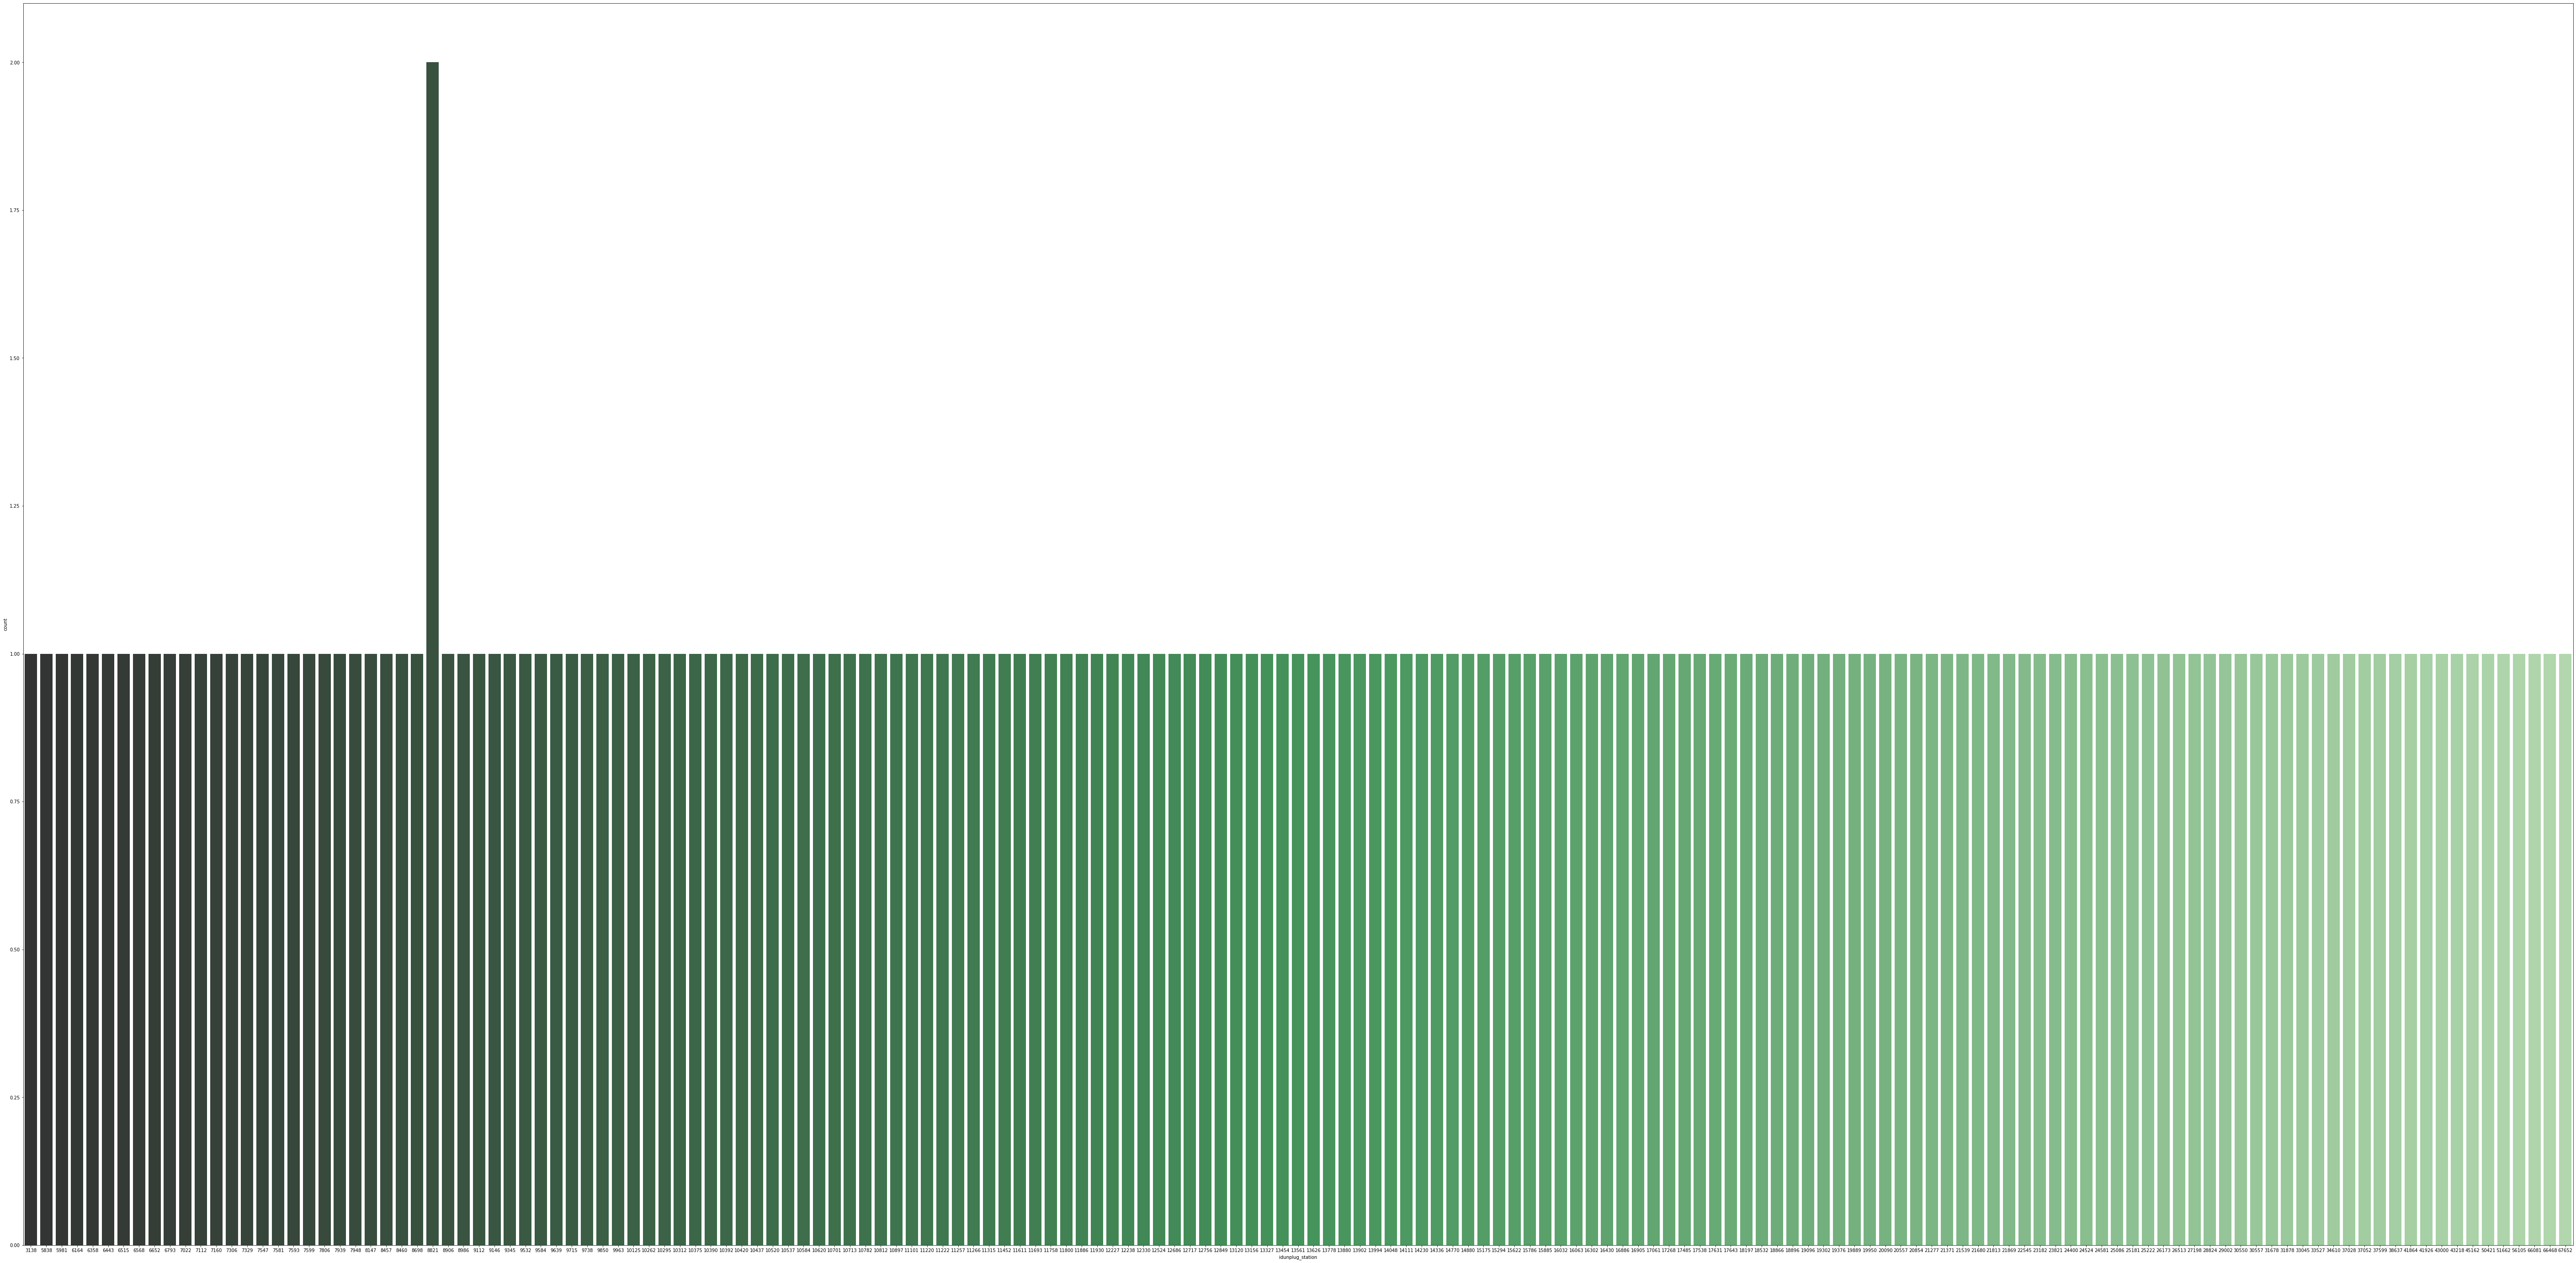

In [ ]:
fig = plt.figure(figsize=(100,50))
sns.countplot(x=data["idunplug_station"].value_counts(sort=True), data=data, hue_order=True, palette="Greens_d")


#### The most used stations for users

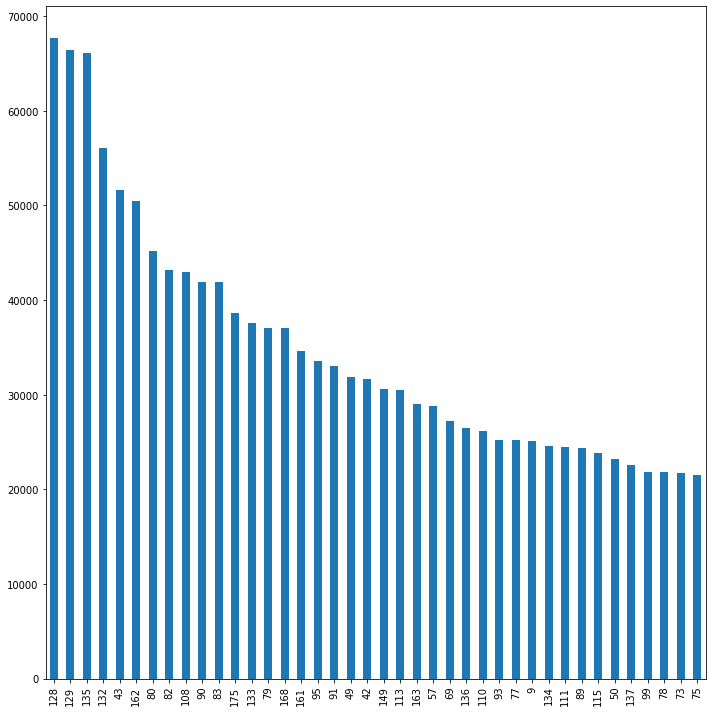

In [ ]:
# values_num_station = jan18["idunplug_station"].value_counts(sort=True).head(100)
most_stations = data["idunplug_station"].value_counts(sort=True).head(40)
fig = plt.figure(figsize=(10,10))
most_stations.plot(kind='bar')
plt.tight_layout()

In [ ]:
data["idunplug_station"].value_counts(sort=True)

128    67652
129    66468
135    66081
132    56105
43     51662
       ...  
173     6358
123     6164
5       5981
124     5838
29      3138
Name: idunplug_station, Length: 166, dtype: int64

In [ ]:
# fig, ax = plt.hist()
# y = jan18["idunplug_station"].value_counts(sort=True).head(3)
# x = ["129", "43", "57"]
# n = ax.hist(x, density=1)
# ax.hist(x, y)
# ax.set_xlabel('number station')
# ax.set_ylabel('frequence')
# ax.set_title(r'Testing')
# # Tweak spacing to prevent clipping of ylabel
# plt.show()

In [ ]:
# fig = plt.figure(figsize=(50,50))
# sns.countplot(x=jan18["idunplug_station"].value_counts(sort=True).head(5), data=jan18, palette="Greens_d")

In [ ]:
# aa=jan18[['idunplug_base']].rank()
# plt.hist(aa, bins = 8)

(array([1., 0., 0., 0., 0., 0., 0., 2., 3., 4., 3., 3., 4., 3., 2., 5., 3.,
        5., 3., 8., 8., 4., 5., 5., 3., 3., 2., 4., 3., 5., 2., 2., 2., 1.,
        3., 2., 1., 3., 2., 3., 1., 1., 2., 2., 1., 3., 0., 1., 1., 3., 3.,
        0., 1., 0., 1., 0., 1., 1., 2., 3., 0., 0., 1., 1., 0., 1., 0., 0.,
        0., 1., 1., 0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 2., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1.]),
 array([ 3138.        ,  3506.65142857,  3875.30285714,  4243.95428571,
         4612.60571429,  4981.25714286,  5349.90857143,  5718.56      ,
         6087.21142857,  6455.86285714,  6824.51428571,  7193.1657

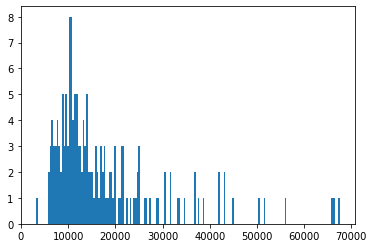

In [ ]:
plt.hist(data['idunplug_station'].value_counts(), bins=175)

In [ ]:
# cuelgan = jan18[   (jan18.idplug_station == 85)
#                   |(jan18.idplug_station == 74)
#                   |(jan18.idplug_station == 69)
#                   |(jan18.idplug_station == 65)
#                   |(jan18.idplug_station == 60)
#                   |(jan18.idplug_station == 79)
#                   |(jan18.idplug_station == 77)
#                   |(jan18.idplug_station == 76)
#                   |(jan18.idplug_station == 71)
#                   |(jan18.idplug_station == 68)
#                   |(jan18.idplug_station == 63)]

# #Gráfico
# import seaborn as sns
# import matplotlib.pyplot as plt
# graph = cuelgan['idunplug_station'].value_counts(normalize=True, sort=True)
# plt.figure(figsize=(50,10))
# sns.barplot(graph.index, graph.values, alpha=1)
# plt.xlabel('Estaciones donde van', fontsize=12)
# plt.ylabel('% de frecuencia', fontsize=12)
# plt.show()

# # Numero de usurios que llegan por estación, ordenado de mayor a menor
# cuelgan['idplug_station'].value_counts(sort=True).head()

### Type of user

* 0: Could not determine user type
* 1: Annual user (holder of an annual pass)
* 2: Occasional user
* 3: Company worker




In [ ]:
data['user_type'].value_counts()

3    2385759
1     534546
2       6324
Name: user_type, dtype: int64

In [ ]:
data['user_type'].describe()

count    2.926629e+06
mean     2.632541e+00
std      7.731308e-01
min      1.000000e+00
25%      3.000000e+00
50%      3.000000e+00
75%      3.000000e+00
max      3.000000e+00
Name: user_type, dtype: float64

### Zip Code

In [ ]:
## ZIP CODE 

# jan18['zip_code'].replace('^(?!^(?:0[1-9]|[1-4]\d|5[0-2])\d{3}$).*', np.nan, regex=True, inplace=True) #transform empty data
# len(jan18[-jan18['zip_code'].duplicated(keep=False)]) #count the data
# jan18['zip_code'].value_counts()
# # User by postal code withouth clean
# jan18.groupby(['zip_code'])['id'].count()

# # Function to clean of postal code 1/3
# def make_int(s):
#     s = s.strip()
#     return int(s) if (s and s.isdigit()) else 0

#     # Function to clean of postal code 2/3
# jan18['zip_code_as_int'] = jan18['zip_code'].apply(lambda x: make_int(x))

# # Function to clean of postal code 3/3
# zip_id = jan18.groupby(['zip_code_as_int'])['id'].count()

In [ ]:
# plt.scatter(top_idunp, top_idp)

### Correlation of idunplug base, idunplug station, idplug base, idplug station, user type and travel time

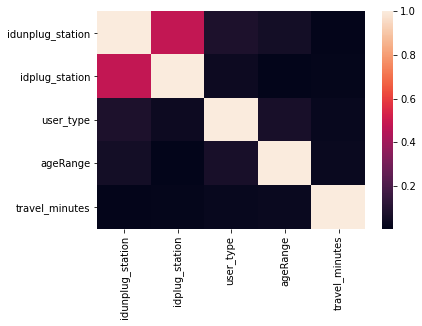

In [ ]:
sns.heatmap(data.loc[:, ['idunplug_station', 'idplug_station', 'user_type', 'ageRange', 'travel_minutes']].corr(), linewidths=0.0001)

In [ ]:
data.corr()

idunplug_station  ...  travel_minutes
idunplug_station           1.000000  ...        0.012698
Longitud_idunplug          0.004877  ...       -0.003298
Latitud_idunplug           0.293414  ...        0.000549
idplug_station             0.481429  ...        0.015928
Longitud_idplug            0.045166  ...        0.005282
Latitud_idplug             0.124169  ...        0.006221
user_type                  0.082160  ...        0.025841
travel_time                0.012698  ...        1.000000
ageRange                   0.057669  ...        0.029984
travel_minutes             0.012698  ...        1.000000

[10 rows x 10 columns]

In [ ]:
# sns.pairplot(jan18, x_vars=user_day_code, y_vars=idplugbase)

In [ ]:
%%time
# plt.scatter(userdaycode, idplugbase)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


CPU times: user 3min 38s, sys: 1.95 s, total: 3min 40s
Wall time: 3min 39s


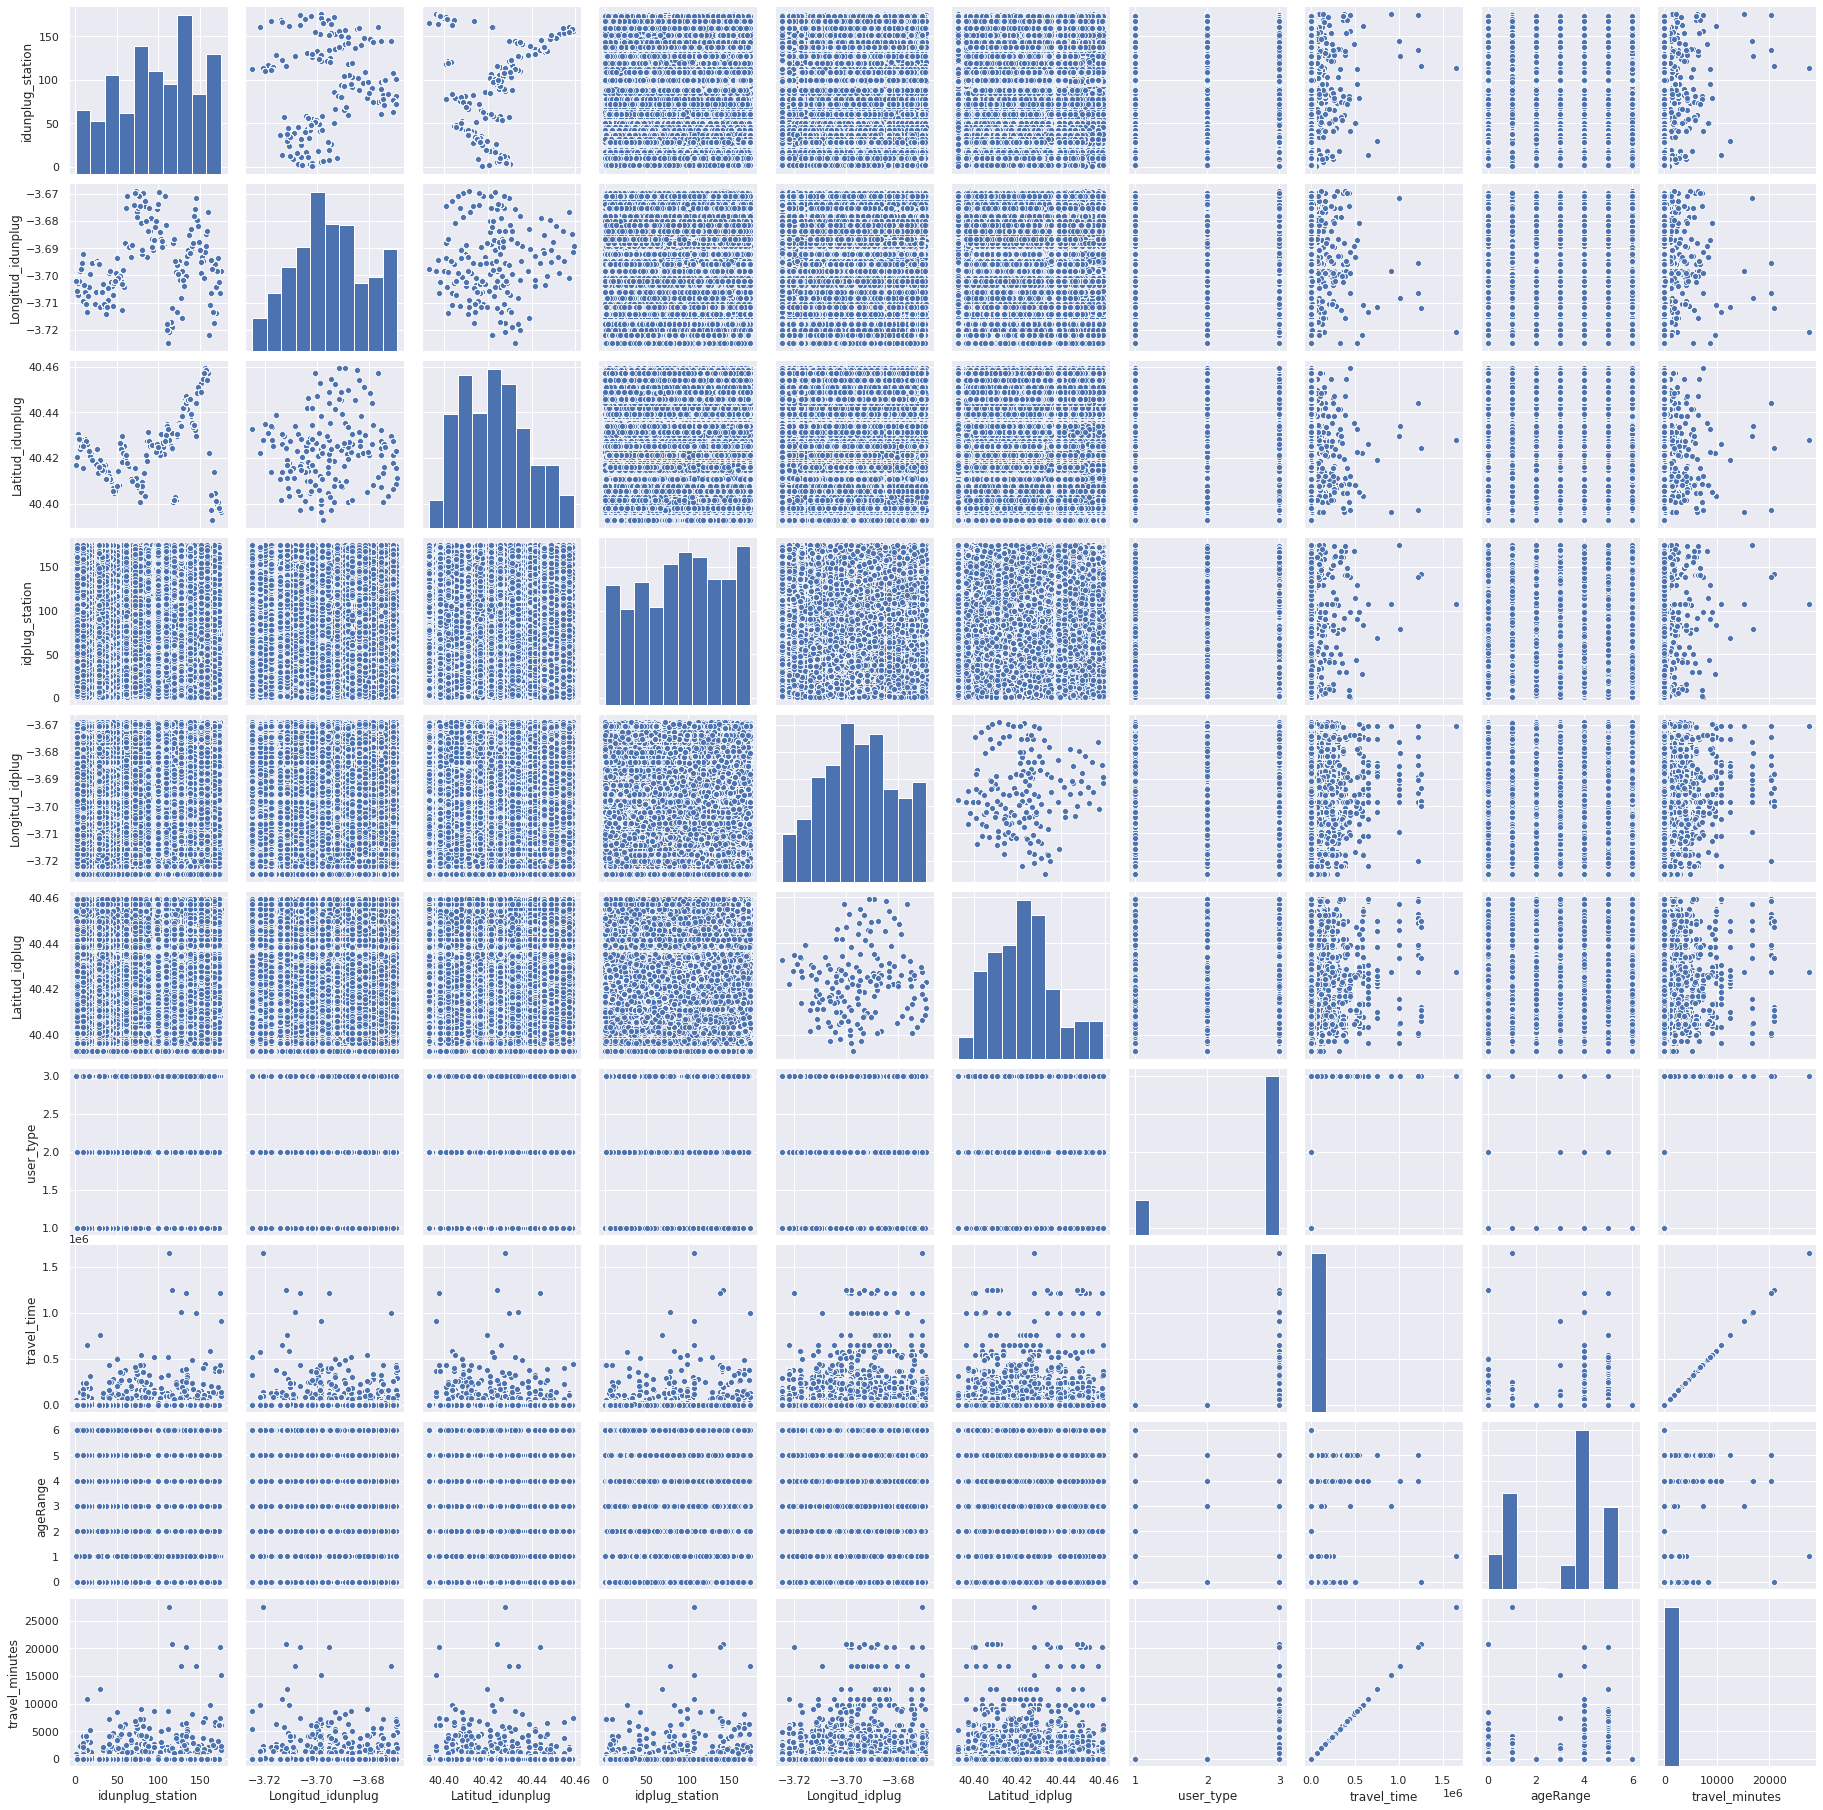

In [ ]:
%%time
sns.set()
sns.pairplot(data)

### Distance Calculate using Haversine

In [ ]:
#Calculate KMs 
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(data):
  lon1 = data['Longitud_idunplug']
  lat1 = data['Latitud_idunplug']
  lon2 = data['Longitud_idplug']
  lat2 = data['Latitud_idplug']
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) #change a radians
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * arcsin(sqrt(a))
  km = 6367 * c # Tierra es una esfera perfecta de radio RT = 6367
  return km 
# data['distance'] = data.apply(lambda data: haversine(data), axis=1

In [ ]:
data['distance'] = data.apply(lambda data: haversine(data), axis=1)

(array([574439., 477863., 505249., 518795., 378883., 250042., 122359.,
         64108.,  25885.,   9006.]),
 array([0.        , 0.74116649, 1.48233297, 2.22349946, 2.96466595,
        3.70583244, 4.44699892, 5.18816541, 5.9293319 , 6.67049838,
        7.41166487]),
 <a list of 10 Patch objects>)

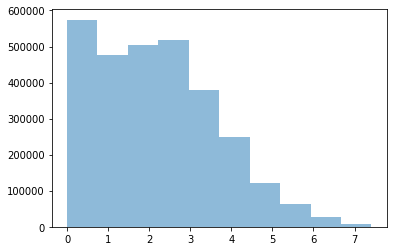

In [ ]:
plt.hist(data.distance, alpha =0.5)

### Slope Calculate

In [ ]:
lon1 = data['Longitud_idunplug']
lat1 = data['Latitud_idunplug']
lon2 = data['Longitud_idplug']
lat2 = data['Latitud_idplug']
m = []
def slope():
  if slope == 0:
      m = 0

  else: 
    lat_dif = lat2-lat1
    lon_dif = lon2-lon1
    m = (lat_dif/lon_dif) * 100
  return m


In [ ]:
m

[]

In [ ]:

lon1 = data['Longitud_idunplug']
lat1 = data['Latitud_idunplug']
lon2 = data['Longitud_idplug']
lat2 = data['Latitud_idplug']
lat_dif = lat2-lat1
lon_dif = lon2-lon1
m = ""

In [ ]:
if lon_dif == 0:
  m = 0
else:
  m = (lat_dif/lon_dif) * 100

ValueError: ignored

In [ ]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# import pandas
# stations_2019 = pandas.read_csv("stations_2019.csv")
result = pd.DataFrame()


# DATOS INTRODUCIDOS POR EL USUARIO
def get_source():
    return input(f"\n Indica el número de la estación donde te encuentras. \n"
                 f"Este numero debe estar comprendido entre  min: {min} y max: {max}: ")


def get_destination():
    return input(f'\n Indica el número de la estación donde vas. \n'
                 f'Este numero debe estar comprendido entre  min: {min} y max: {max}: ')


# PROCESO DE VALIDACION - NO ES NECESARIO PERO PARA QUE PRACTIQUES
min = sorted(pd.unique(stations_2019['ids']))[0]
max = sorted(pd.unique(stations_2019['ids']))[-1]


def validation_input(i, _min, _max):
    return True if (i and _max > input > _min and isinstance(i, float)) else False


# OBTENCION DE LA LATITUD Y LONGITUD
def get_latitude_and_longitude_by_input(type, r):
    # para ver si el df es vacio o no
    while r.empty:
        # devulevo la entrada source si type == 'source' sino devulevo destination
        i = get_source() if type == 'source' else get_destination()
        # localiza en la columna ids del df stations_2019 si existe algun valor igual a i
        # si existe te devuleve su lati y longi y sino te devuelve un df vacio
        r = stations_2019.loc[stations_2019['ids'].astype(str) == i, ['LATITUD', 'LONGITUD']]
    la_s = r['LATITUD'].values[0]
    lo_s = r['LONGITUD'].values[0]
    return la_s, lo_s


# CALCULO DE LA PENDIENTE
def print_slope(latitud_d, latitud_s, longitude_d, longitude_s):
    dif_lon = longitude_d - longitude_s
    if dif_lon == 0:
        print("\n No hay pendiente")
    else:
        slope = (latitud_d - latitud_s) / (longitude_d - longitude_s) * 100
        print(f"\n La pendiente es: {slope}")


latitud_s, longitude_s = get_latitude_and_longitude_by_input('source', result)
latitud_d, longitude_d = get_latitude_and_longitude_by_input('destination', result)

# print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_s} - LATITUD:{longitude_s} ")
# print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_d} - LATITUD:{longitude_d} ")

print_slope(latitud_d, latitud_s, longitude_d, longitude_s)


 Indica el número de la estación donde te encuentras. 
Este numero debe estar comprendido entre  min: 1 y max: 211: 20

 Indica el número de la estación donde vas. 
Este numero debe estar comprendido entre  min: 1 y max: 211: 0

 Indica el número de la estación donde vas. 
Este numero debe estar comprendido entre  min: 1 y max: 211: 20

 No hay pendiente


In [ ]:
m

0           157.267688
1          -252.811876
2           -82.732310
3           448.197428
4         -5121.025113
              ...     
2926624     798.133425
2926625      13.477390
2926626     -45.469354
2926627     608.376404
2926628     608.376404
Length: 2926629, dtype: float64

In [ ]:
data.head()

id_x_x  ...  distance
0  5a505acd2f384319304ed614  ...  0.129976
1  5a505ad02f384319304ed925  ...  1.547515
2  5a505ad02f384319304ed925  ...  1.127794
3  5a505adb2f384319304ee2dd  ...  1.796349
4  5a505adb2f384319304ee2dd  ...  1.119217

[5 rows x 18 columns]

In [ ]:
data['slope'] = m

In [ ]:
data.head()

id_x_x  ...        slope
0  5a505acd2f384319304ed614  ...   157.267688
1  5a505ad02f384319304ed925  ...  -252.811876
2  5a505ad02f384319304ed925  ...   -82.732310
3  5a505adb2f384319304ee2dd  ...   448.197428
4  5a505adb2f384319304ee2dd  ... -5121.025113

[5 rows x 19 columns]

In [ ]:
# import matplotlib.pyplot as plt
# fig=plt.figure()
# fig.set_figheight(10)
# fig.set_figwidth(25)

# plt.bar(data['distance'], data['slope'], align='center', alpha=0.5, width=0.8, color = 'gray')

# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# fig=plt.figure()
# fig.set_figheight(10)
# fig.set_figwidth(25)

# plt.scatter(data['distance'], data['slope'], align='center', alpha=0.5, width=0.8, color = 'gray')

# plt.show()

In [ ]:
data['slope'].describe()

count    2.669874e+06
mean    -1.425582e+02
std      9.020080e+03
min     -5.777951e+05
25%     -1.002512e+02
50%     -3.150867e+00
75%      1.098552e+02
max      4.139666e+05
Name: slope, dtype: float64

In [ ]:
data.head(3)

_id  ...       slope
0  5a505acd2f384319304ed614  ...  157.267688
1  5a505ad02f384319304ed925  ... -252.811876
2  5a505ad02f384319304ed925  ...  -82.732310

[3 rows x 20 columns]

In [ ]:
data['idplug_station'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175])

In [ ]:
data['idunplug_station'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  16,  17,  18,  19,  20,  24,  25,  26,  27,  29,  30,  31,
        32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  65,  67,  69,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
       127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175])

In [ ]:
idunplug_station = data['idplug_station'].sort_values().unique()
idunplug_station

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175])

In [ ]:
data.head(3)

_id  ...       slope
0  5a505acd2f384319304ed614  ...  157.267688
1  5a505ad02f384319304ed925  ... -252.811876
2  5a505ad02f384319304ed925  ...  -82.732310

[3 rows x 20 columns]

#### Este no funciona

In [ ]:
origen = int(input("Indica el nº de la estación donde te encuentras: ")) #ask where is your positions
# destino = int(input("Indica el nº de la estación a la que vas: "))
idunplug_station = data['idplug_station'].sort_values().unique() # search value in idunplug_station
# idplug_station = data['idplug_station'].sort_values().unique()
 
lon1 = data['Longitud_idunplug'].sort_values().unique()
lat1 = data['Latitud_idunplug']
 
 
# lon2 = data['Longitud_idplug']
# lat2 = data['Latitud_idplug']
 
# lat_dif = lat2-lat1
# lat_dif
# lon_dif = lon2-lon1
# lon_dif
# m = lat_dif/lon_dif
# m = m*100
 
# def calculating_slope(origen, destino):
result1 = ""
# result2 = ""
 
for i in idunplug_station:
    if i == origen:
          result1 = result1
#     else:
#       print("No disponemos de esa estación")
 
      # for j in idplug_station:
      #   if j == destino:
      #       result2 = lon2[destino], lat2[destino]
 
# lat_dif = result2[1] - result1[1]
# lon_dif = result2[0] - result1[0]
# m = lat_dif/lon_dif
# m = m * 100
 
 
        # else:
          # print("No disponemos de esa estación")

Indica el nº de la estación donde te encuentras: 7


In [ ]:
df.columns

Index(['id', 'Gis_X', 'Gis_Y', 'Fecha de Alta', 'Distrito', 'Barrio', 'Calle',
       'Nº Finca', 'Tipo de Reserva', 'Anclajes', 'LONGITUD', 'LATITUD',
       'DIRECCION', 'Year', 'ids'],
      dtype='object')

#### Este funciona pero no entra bien el bucle

In [ ]:
result_origen= ""
# result_destino = ""
origen = int(input("Indica el nº de la estación donde te encuentras: "))
# destino = int(input("Indica el nº de la estación a donde vas: "))
for i, row in stations_2019.iterrows(): #tomo como referencia el dataframe de estaciones 2019 para obtener latitud y longitud
    if i == origen:
      result_origen = row[10], row[11]
      break 
    else: 
      print("No se encuentra el estacionamiento")
# print(result_origen)

# for j, row in stations_2019.iterrows():   
#       if j == destino:
#         result_destino = row[10], row[11]

# lat_dif = result_destino[1] - result_origen[1]
# lon_dif = result_destino[0] - result_origen[0]
# m = lat_dif/lon_dif
# m = m * 100

print(result_origen)
# print(result_destino)

Indica el nº de la estación donde te encuentras: 65
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No se encuentra el estacionamiento
No 

In [ ]:
stations_2019.head()

id      Gis_X       Gis_Y  ... ids idunplug_station idplug_station
0  001 a  440443,61  4474290,65  ...   1                1              1
2      2  440134,83  4474678,23  ...   2                2              2
3      3  440012,98  4475760,68  ...   3                3              3
4      4   440396,4  4475565,36  ...   4                4              4
5      5   440446,9  4475539,69  ...   5                5              5

[5 rows x 17 columns]

In [ ]:
result_origen_lat= ""
result_origen_lon = ""
origen = int(input("Indica el nº de la estación donde te encuentras: "))
# destino = int(input("Indica el nº de la estación a donde vas: ")) 


result_origen_lat, result_origen_lon =  stations_2019.iloc[stations_2019.index == origen, [10, 11]].to_list()

Indica el nº de la estación donde te encuentras: 65


AttributeError: ignored

In [ ]:
pru = stations_2019.iloc[stations_2019.index == 65, [10, 11]]
pru.iloc[:, 0]

65   -3.693135
Name: LONGITUD, dtype: float64

In [ ]:
pru.head()

LONGITUD    LATITUD
65 -3.693135  40.410829

In [ ]:
for i, row in stations_2019.iterrows(): 
    if i == origen:
        result_origen = row[10], row[11]
        break
else:
    print("No existe esa estación") 

In [ ]:
stations_2019[stations_2019['ids'] == 65]

id      Gis_X       Gis_Y  ... ids idunplug_station idplug_station
64  65  441513,54  4474236,11  ...  65               65             65

[1 rows x 17 columns]

In [ ]:
data.head(5)

_id  ...        slope
0  5a505acd2f384319304ed614  ...   157.267688
1  5a505ad02f384319304ed925  ...  -252.811876
2  5a505ad02f384319304ed925  ...   -82.732310
3  5a505adb2f384319304ee2dd  ...   448.197428
4  5a505adb2f384319304ee2dd  ... -5121.025113

[5 rows x 20 columns]

#### Este no funciona, probando nueva alternativa

In [ ]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# import pandas
# stations_2019 = pandas.read_csv("stations_2019.csv")
result = pandas.DataFrame()


# DATOS INTRODUCIDOS POR EL USUARIO
def get_source():
    return input(f"\n Indica el número de la estación donde te encuentras. \n"
                 f"Este numero debe estar comprendido entre  min: {min} y max: {max}: ")


def get_destination():
    return input(f'\n Indica el número de la estación donde vas. \n'
                 f'Este numero debe estar comprendido entre  min: {min} y max: {max}: ')


# PROCESO DE VALIDACION - NO ES NECESARIO PERO PARA QUE PRACTIQUES
min = sorted(pandas.unique(stations_2019['ids']))[0]
max = sorted(pandas.unique(stations_2019['ids']))[-1]


def validation_input(i, _min, _max):
    return True if (i and _max > input > _min and isinstance(i, float)) else False


# OBTENCION DE LA LATITUD Y LONGITUD
def get_latitude_and_longitude_by_input(type, r):
    # para ver si el df es vacio o no
    while r.empty:
        # devulevo la entrada source si type == 'source' sino devulevo destination
        i = get_source() if type == 'source' else get_destination()
        # localiza en la columna ids del df stations_2019 si existe algun valor igual a i
        # si existe te devuleve su lati y longi y sino te devuelve un df vacio
        r = stations_2019.loc[stations_2019['ids'].astype(str) == i, ['LATITUD', 'LONGITUD']]
    la_s = r['LATITUD'].values[0]
    lo_s = r['LONGITUD'].values[0]
    return la_s, lo_s


# CALCULO DE LA PENDIENTE
def print_slope(latitud_d, latitud_s, longitude_d, longitude_s):
    dif_lon = longitude_d - longitude_s
    if dif_lon == 0:
        print("\n No es posible el calculo de la pendiente")
    else:
        slope = (latitud_d - latitud_s) / (longitude_d - longitude_s) * 100
        print(f"\n La pendiente es: {slope}")


latitud_s, longitude_s = get_latitude_and_longitude_by_input('source', result)
latitud_d, longitude_d = get_latitude_and_longitude_by_input('destination', result)

print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_s} - LATITUD:{longitude_s} ")
print(f"\nPara el origen hemos encontrado los siguientes datos: LONGITUD:{latitud_d} - LATITUD:{longitude_d} ")

print_slope(latitud_d, latitud_s, longitude_d, longitude_s)

In [ ]:
data[data['idunplug_station'] == 6]

_id  ...       slope
0       5a505acd2f384319304ed614  ...  157.267688
1       5a505ad02f384319304ed925  ... -252.811876
2       5a505ad02f384319304ed925  ...  -82.732310
5       5a505ad02f384319304ed926  ...  -82.732310
6       5a505ad12f384319304eda0f  ...   68.368922
...                          ...  ...         ...
101068  5a78e51d2f38433d0c83e0eb  ...  -12.905903
101069  5a78e51d2f38433d0c83e0eb  ...         NaN
101070  5a78e51d2f38433d0c83e0eb  ...         NaN
101071  5a78e51d2f38433d0c83e0eb  ...  -16.352456
101072  5a78e51d2f38433d0c83e0eb  ...  128.381856

[12524 rows x 20 columns]

In [ ]:
data.head(5)

_id  ...        slope
0  5a505acd2f384319304ed614  ...   157.267688
1  5a505ad02f384319304ed925  ...  -252.811876
2  5a505ad02f384319304ed925  ...   -82.732310
3  5a505adb2f384319304ee2dd  ...   448.197428
4  5a505adb2f384319304ee2dd  ... -5121.025113

[5 rows x 20 columns]

In [ ]:
# lat1[origen]
lon1[0]

-3.7248727329999998

In [ ]:
df[df['ids'] == 7]

id      Gis_X       Gis_Y  ...                DIRECCION  Year ids
7  7  440811,97  4475187,49  ...   CALLE DE HORTALEZA, 75  2014   7

[1 rows x 15 columns]

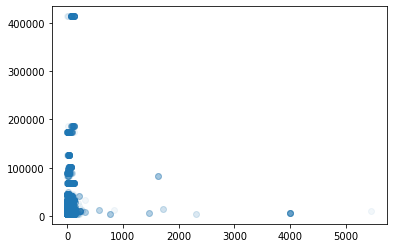

In [ ]:
hight_slope = data[data['slope'] >= 4139.666066302884]
plt.scatter(hight_slope['travel_minutes'], hight_slope['slope'], alpha=0.0555)

In [ ]:
hight_slope.groupby('user_type').count()#hight_slope(subida, es decir pendiente)

_id  user_day_code  ...  distance  slope
user_type                        ...                 
1           3885           3885  ...      3885   3885
2             34             34  ...        34     34
3          21652          21652  ...     21652  21652

[3 rows x 19 columns]

In [ ]:
low_slope.groupby('user_type').count()

_id  user_day_code  ...  distance  slope
user_type                      ...                 
1            5              5  ...         5      5
3          329            329  ...       329    329

[2 rows x 19 columns]

In [ ]:
low_slope.head()

_id  ...          slope
576499  5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576500  5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576501  5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576502  5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576503  5a70fb7d2f3843020c0f2fcc  ... -577795.071283

[5 rows x 20 columns]

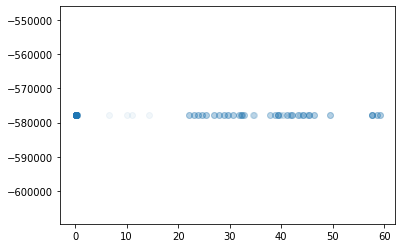

In [ ]:
low_slope = data[data['slope'] == -577795.0712825452]
plt.scatter(low_slope['travel_minutes'], low_slope['slope'], alpha=0.0555)

In [ ]:
low_slope.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 576499 to 2788734
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                334 non-null    object 
 1   user_day_code      334 non-null    object 
 2   idunplug_station   334 non-null    int64  
 3   Distrito_idunplug  334 non-null    object 
 4   Barrio_idunplug    334 non-null    object 
 5   Longitud_idunplug  334 non-null    float64
 6   Latitud_idunplug   334 non-null    float64
 7   idplug_station     334 non-null    int64  
 8   Distrito_idplug    334 non-null    object 
 9   Barrio_idplug      334 non-null    object 
 10  Longitud_idplug    334 non-null    float64
 11  Latitud_idplug     334 non-null    float64
 12  user_type          334 non-null    int64  
 13  travel_time        334 non-null    int64  
 14  unplug_hourTime    334 non-null    object 
 15  ageRange           334 non-null    int64  
 16  zip_code         

In [ ]:
low_slope[low_slope['user_type']!=3]

_id  ...          slope
2200146  5a7793a42f384326441b8861  ... -577795.071283
2622974  5a73f2cb2f38430a0c4d9aa1  ... -577795.071283
2622977  5a73f2ce2f38430a0c4d9dd9  ... -577795.071283
2787664  5a6ab99f2f38432904c56343  ... -577795.071283
2788734  5a72a0b82f3843390426c41c  ... -577795.071283

[5 rows x 20 columns]

In [ ]:
low_slope[low_slope['user_type']==3]

_id  ...          slope
576499   5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576500   5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576501   5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576502   5a70fb7d2f3843020c0f2fcc  ... -577795.071283
576503   5a70fb7d2f3843020c0f2fcc  ... -577795.071283
...                           ...  ...            ...
1532204  5a53faea2f3843205cd6ff61  ... -577795.071283
1532205  5a53faea2f3843205cd6ff61  ... -577795.071283
1532304  5a53faea2f3843205cd6ff62  ... -577795.071283
1532305  5a53faea2f3843205cd6ff62  ... -577795.071283
1532306  5a53faea2f3843205cd6ff62  ... -577795.071283

[329 rows x 20 columns]

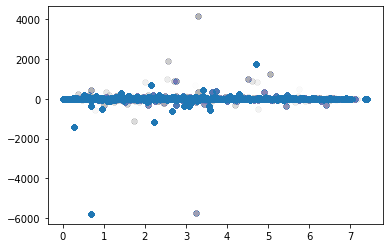

In [ ]:

plt.scatter(data['distance'],data['slope'], alpha=0.0055)

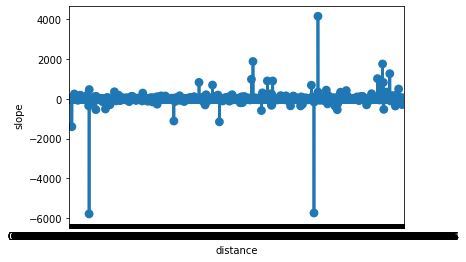

In [ ]:
import seaborn as sns
sns.pointplot(x="distance", y="slope",data=data)

## Machine Learning Models

#### Shit Lineal Regression Model:
###### Objective variable is disengaging the bicycle (Idunplug_station) and features variable is bicycle hitch (Idplug_station). 

In [ ]:
y_train = jan18['idunplug_station'] #series
X_train = jan18[['idplug_station']] #dataframe

In [ ]:
from sklearn.linear_model import LinearRegression

# Create an instance of the model
reg = LinearRegression()

# Train the regressor
model1 = reg.fit(X_train, y_train)

In [ ]:
model1.score(X_train, y_train)

0.02588488314618631

In [ ]:
reg.coef_

array([0.15646287])

In [ ]:
reg.intercept_

75.60738735117673

In [ ]:
y_train = reg.intercept_ + reg.coef * X

##### Predictions18 is of values the idunplug_station column. 

In [ ]:
predictions18 = jan18[['idunplug_station']]
# predict = reg.predict(jan18[['idunplug_station']])
predict = reg.predict(predictions18)
jan18['predictions18'] = predict

In [ ]:
jan18.describe()

idunplug_station  idunplug_base  ...   predictions2  predictions18
count     263701.000000  263701.000000  ...  263701.000000  263701.000000
mean          89.599611      11.824794  ...      89.790980      89.626400
std           51.125729       7.527186  ...       8.073925       7.999278
min            1.000000       1.000000  ...      75.763850      75.763850
25%           47.000000       5.000000  ...      83.274068      82.961142
50%           87.000000      11.000000  ...      89.532583      89.219657
75%          134.000000      19.000000  ...      96.729875      96.573412
max          175.000000      30.000000  ...     389.784838     102.988390

[8 rows x 10 columns]

In [ ]:
jan18.loc[:, ['idunplug_station','idplug_station', 'predictions18']]

idunplug_station  idplug_station  predictions18
0                      6               7      76.546165
1                     24             117      79.362496
2                     24             117      79.362496
3                     82             110      88.437343
4                    169              58     102.049613
...                  ...             ...            ...
263697                99              52      91.097212
263698                 8              52      76.859090
263699               135               6      96.729875
263700               135               6      96.729875
263701                57              58      84.525771

[263701 rows x 3 columns]

In [ ]:
lm1 = sm.OLS(y_train, sm.add_constant(X_train))
lm_model= lm1.fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       idunplug_station   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     6613.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        16:58:49   Log-Likelihood:            -1.4084e+06
No. Observations:              263701   AIC:                         2.817e+06
Df Residuals:                  263699   BIC:                         2.817e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             75.6074      0.198    381.498      0.000      75.219      75.996
idplug_station     0.1565      0.002     81.318      0.000       0.153       0.160
==============================================================================
Omnibus:                   109495.333   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13313.460
Skew:                          -0.009   Prob(JB):                         0.00
Kurtosis:                       1.899   Cond. No.                         208.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from sklearn.metrics import mean_absolute_error

# Use against predictions
error1 = mean_absolute_error(reg.predict(X_train), y_train)

#### Another Linear Regression Model 

##### Objective variable is disengaging the bicycle (Idunplug_station) and features variable is bicycle hitch, user type and travel time(Idplug_station, user_type and travel_time).

In [ ]:
y_tr = jan18.idunplug_station
X_tr = jan18.loc[:, ['idplug_station', 'user_type', 'travel_time']]

In [ ]:
X_tr.shape
y_tr.shape

(263702,)

In [ ]:
from sklearn.linear_model import LinearRegression

reg2 = LinearRegression()

model2 = reg2.fit(X_tr, y_tr)

In [ ]:
reg2.coef_

array([1.59419313e-01, 4.48931827e+00, 2.74409860e-05])

In [ ]:
reg2.intercept_

69.79792758005563

In [ ]:
reg2.score(X_tr, y_tr)

0.028981333112635954

### Logistic Regression ML

#### This is Logistic Regression without split test and train

In [ ]:
data.columns

Index(['_id', 'user_day_code', 'idunplug_station', 'Distrito_idunplug',
       'Barrio_idunplug', 'Longitud_idunplug', 'Latitud_idunplug',
       'idplug_station', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug',
       'Latitud_idplug', 'user_type', 'travel_time', 'unplug_hourTime',
       'ageRange', 'zip_code', 'travel_minutes', 'distance', 'slope'],
      dtype='object')

In [ ]:
data['user_type']

0          1
1          1
2          1
3          1
4          1
          ..
2926624    1
2926625    1
2926626    1
2926627    1
2926628    1
Name: user_type, Length: 2926629, dtype: int64

In [ ]:
from sklearn.linear_model import LogisticRegression
y_train = data['user_type']
X_train = data[['distance']]
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

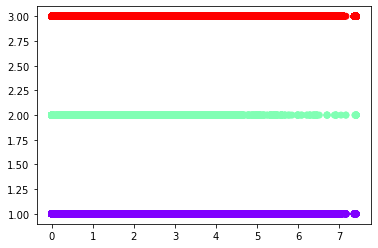

In [ ]:
plt.scatter(X_train, y_train, c=y_train, cmap='rainbow')

In [ ]:
model1.coef_

array([[-0.04405879],
       [-0.13830433],
       [ 0.18236312]])

In [ ]:
model1.intercept_

array([ 1.07970338, -3.19579896,  2.11609558])

In [ ]:
model1.score(X_train,y_train)

0.8151901043828924

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, model1.predict(X_train))

0.8151901043828924

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, model1.predict(X_train)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    534546
           2       0.00      0.00      0.00      6324
           3       0.82      1.00      0.90   2385759

    accuracy                           0.82   2926629
   macro avg       0.27      0.33      0.30   2926629
weighted avg       0.66      0.82      0.73   2926629



The recall means "how many of this class you find over the whole number of element of this class"

The precision will be "how many are correctly classified among that class"

The f1-score is the harmonic mean between precision & recall

The support is the number of occurence of the given class in your dataset (so you have 534546 of class 1  6324 of class 2 and 2385759 of class 3, which is a really well balanced dataset)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_train, model1.predict(X_train))

array([[      0,       0,  534546],
       [      0,       0,    6324],
       [      0,       0, 2385759]])

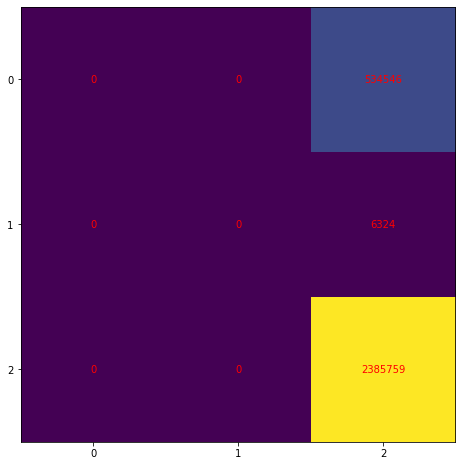

In [ ]:
cm = confusion_matrix(y_train, model1.predict(X_train))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=range(3))
ax.yaxis.set(ticks=range(3))
for i in range(3):
    for j in range(3):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [ ]:
print(classification_report(y_train, clr.predict(X_train)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    534546
           2       0.00      0.00      0.00      6324
           3       0.82      1.00      0.90   2385759

    accuracy                           0.82   2926629
   macro avg       0.27      0.33      0.30   2926629
weighted avg       0.66      0.82      0.73   2926629



### Logistic Regression ML (2)

#### This is Logistic Regression with split test and train

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
y = data['user_type']
x = data[['distance']]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0) #split data

In [ ]:
model2 = LogisticRegression() #creating a model2
model2.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model2.coef_

array([[-0.04357775],
       [-0.14075628],
       [ 0.18433403]])

In [ ]:
model2.intercept_

array([ 1.07791173, -3.18854632,  2.11063458])

In [ ]:
model2.score(x_train,y_train)

0.8150402218056857

In [ ]:
y_pred = model2.predict(x_test)

In [ ]:
confusion_matrix(y_test, y_pred)

array([[     0,      0, 160080],
       [     0,      0,   1874],
       [     0,      0, 716035]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model2.predict(x_train)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    374466
           2       0.00      0.00      0.00      4450
           3       0.82      1.00      0.90   1669724

    accuracy                           0.82   2048640
   macro avg       0.27      0.33      0.30   2048640
weighted avg       0.66      0.82      0.73   2048640



### Logistic Regression ML (3)


#### This is Logistic Regression with three output variables

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2669874 entries, 0 to 2926628
Data columns (total 21 columns):
 #   Column             Dtype  
---  ------             -----  
 0   _id                object 
 1   user_day_code      object 
 2   idunplug_station   int64  
 3   Distrito_idunplug  object 
 4   Barrio_idunplug    object 
 5   Longitud_idunplug  float64
 6   Latitud_idunplug   float64
 7   idplug_station     int64  
 8   Distrito_idplug    object 
 9   Barrio_idplug      object 
 10  Longitud_idplug    float64
 11  Latitud_idplug     float64
 12  user_type          int64  
 13  travel_time        int64  
 14  unplug_hourTime    object 
 15  ageRange           int64  
 16  zip_code           object 
 17  travel_minutes     float64
 18  distance           float64
 19  slope              float64
 20  broke              int64  
dtypes: float64(7), int64(6), object(8)
memory usage: 528.1+ MB


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

y = data['user_type']
x = data.loc[:,['travel_minutes', 'distance', 'slope']]

In [ ]:
model3 = LogisticRegression()
model3.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model3.score(x_train,y_train)

0.8150402218056857

In [ ]:
y_pred = model3.predict(x_test)
confusion_matrix(y_test, y_pred)

array([[     2, 128222],
       [     0, 672739]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model3.predict(x_train)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00    374466
           2       0.00      0.00      0.00      4450
           3       0.82      1.00      0.90   1669724

    accuracy                           0.82   2048640
   macro avg       0.27      0.33      0.30   2048640
weighted avg       0.66      0.82      0.73   2048640



### Logistic Regression ML (4)


####Crear un modelo que prediga si una bici esta rota o no


In [ ]:
data.head(2)

_id  ...       slope
0  5a505acd2f384319304ed614  ...  157.267688
1  5a505ad02f384319304ed925  ... -252.811876

[2 rows x 20 columns]

In [ ]:
# data['user_type'] = data['user_type'].astype(float)

In [ ]:
data.user_type.unique()

array([1, 3, 2])

In [ ]:
broke_dict = {3:1, 2:0, 1:0}
data['broke'] = data.user_type.map(broke_dict)

In [ ]:
data['broke'].unique()

array([0, 1])

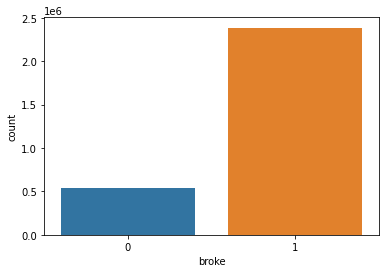

In [ ]:
jan18_broke = sns.countplot(x='broke', data=data)

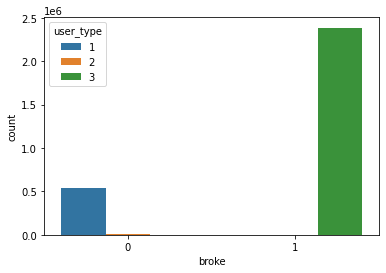

In [ ]:
sns.countplot(x='broke', hue='user_type', data=data)

In [ ]:
data.groupby(['user_type', 'ageRange']).size()

user_type  ageRange
1          0           171031
           1             1721
           2             9080
           3            40327
           4           196346
           5           113024
           6             3017
2          0             6170
           3               54
           4               84
           5               16
3          0            78657
           1           707402
           3           140587
           4           969431
           5           489682
dtype: int64

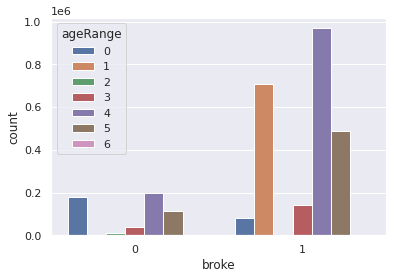

In [ ]:
sns.countplot(x='broke', hue='ageRange', data=data)

In [ ]:
data.slope.isna().sum()

256755

In [ ]:
data = data.dropna(subset=['slope'])

In [ ]:
data.slope.isna().sum()

0

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

y = data['broke'] #pandas Series
x = data.loc[:,['travel_minutes', 'distance', 'slope']] #pandas DataFrame

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state= 0)

In [ ]:
model4 = LogisticRegression()
model4.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
model4.coef_

array([[ 1.00734052e-02,  4.67183385e-02, -5.34177396e-06]])

In [ ]:
model4.intercept_

array([1.35336748])

In [ ]:
model4.score(x_train, y_train)

0.8402540302882266

In [ ]:
y_pred = model4.predict(x_test)

In [ ]:
confusion_matrix(y_test,y_pred)

array([[     2, 128222],
       [     0, 672739]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_train, model4.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00    298552
           1       0.84      1.00      0.91   1570359

    accuracy                           0.84   1868911
   macro avg       0.92      0.50      0.46   1868911
weighted avg       0.87      0.84      0.77   1868911



## Exploration correlation between travel minutes, distance, slope and broke

In [ ]:
vble = data.iloc[:,17:21]
vble.head()

travel_minutes  distance        slope  broke
0        4.733333  0.129976   157.267688      0
1       13.733333  1.547515  -252.811876      0
2       13.733333  1.127794   -82.732310      0
3        5.616667  1.796349   448.197428      0
4        5.616667  1.119217 -5121.025113      0

In [ ]:
vble.corr()

travel_minutes  distance     slope     broke
travel_minutes        1.000000  0.027175  0.001176  0.025662
distance              0.027175  1.000000  0.021183  0.123051
slope                 0.001176  0.021183  1.000000 -0.008352
broke                 0.025662  0.123051 -0.008352  1.000000

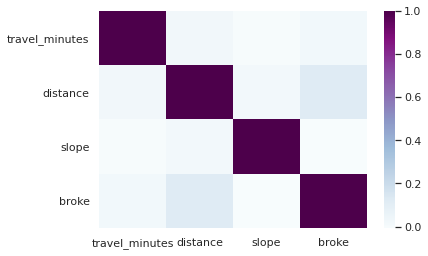

In [ ]:
sns.heatmap(vble.corr(), cmap = "BuPu", linewidths=0.0001)

CPU times: user 15.3 s, sys: 284 ms, total: 15.6 s
Wall time: 15.4 s


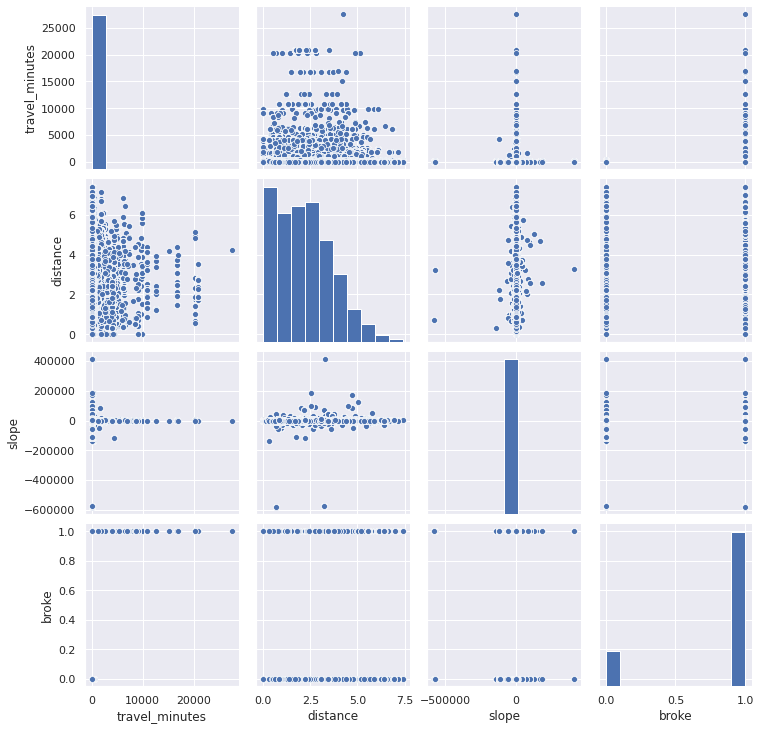

In [ ]:
%%time
sns.set()
sns.pairplot(vble)

# Streamlit


In [204]:
!pip install -q streamlit


     |████████████████████████████████| 7.2MB 2.9MB/s 
     |████████████████████████████████| 112kB 46.2MB/s 
     |████████████████████████████████| 4.4MB 40.7MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 122kB 41.1MB/s 
ERROR: google-colab 1.0.0 has requirement ipykernel~=4.10, but you'll have ipykernel 5.3.4 which is incompatible.


In [205]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -qq ngrok-stable-linux-amd64.zip

--2020-08-25 21:25:38--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.153.26.168, 34.205.126.213, 54.236.206.131, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.153.26.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  48.4MB/s    in 0.3s    

2020-08-25 21:25:39 (48.4 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]



In [206]:
!pip install streamlit-folium #streamlit with folium

     |████████████████████████████████| 102kB 2.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.11.0 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [213]:
get_ipython().system_raw('./ngrok http 8501 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
"import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://1e2714a46f1c.ngrok.io


In [211]:
%%file BiciMad.py
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
import folium.plugins
import plotly.express as px
# from bokeh.plotting import figure, output_file, show
from streamlit_folium import folium_static

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/originalbikestations.csv", sep=';', encoding='utf-8')
df['Year'] = pd.DatetimeIndex(df['Fecha de Alta']).year
year = df['Year']
df = df.rename(columns = {'Número':'id','Número de Plazas':'Anclajes'}) #change de name of column Número
df['ids'] = df['id'].str.rstrip('ampliacionb') #to get only number values
# df_stations = df_stations[onlycolumns]
df['ids'] = df['ids'].astype(int).sort_values() #change values ids and order

d_b = df.groupby(['Distrito'])['Barrio'].count()

locations = df[['LATITUD', 'LONGITUD']] # (Y, X)
locationlist = locations.values.tolist()
df['Locationlist'] = locationlist

st.title("Bici Madrid by: Raquel Socorro")

# fig = plt.figure()
# fig.add_axes(langs)
langs = ['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTÍN', 'TETUÁN', 'CHAMBERÍ', 'MONCLOA-ARAVACA', 'PUENTE DE VALLECAS', 'CIUDAD LINEAL']
# ax.bar(langs,aa)
# plt.show()
# p = plt.figure()
# p.set_figheight(10)
# p.set_figwidth(25)
# p.set_facecolor('white')
# y_pos = np.arange(len(langs))
# plt.bar(y_pos, d_b, align='center', alpha=0.5, width=0.8, color = 'gray')
# plt.xticks(y_pos, langs)
# plt.ylabel('Station by Barrio')
# plt.title('Bike Station by Distrito')

# plt.show()
# st.bokeh_chart(p)
st.title("Puntos de estacionamientos por Distrito")
map1 = folium.Map(location=[40.417110795315295, -3.70199802576925], zoom_start=12)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['Distrito'][point], icon=folium.Icon(color='darkblue', icon_color='white', icon='bicycle', angle=0, prefix='fa')).add_to(map1)
folium_static(map1) 


st.title("Puntos de anclajes por Distrito")
import folium.plugins
folium.plugins.MarkerCluster()
map2 = folium.Map(location=[40.417110795315295, -3.70199802576925], tiles='Stamen Terrain', zoom_start=11)

marker_cluster = folium.plugins.MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df['Distrito'][point], icon=folium.Icon(color='darkblue', icon_color='green', icon='bicycle', angle=0, prefix='fa')).add_to(marker_cluster)
folium_static(map2)



import plotly.express as px
fig2 = px.scatter_geo(df, locations=df['Locationlist'], locationmode='country names', color= df['Distrito'].sort_values(), hover_name=df['Calle'],
                     size=df['Anclajes'], scope='europe', 
                     animation_frame=df['Year'].sort_values(), 
                     projection='stereographic')
# (df, locations="Locationlist", hover_name="Distrito", animation_frame="Year", projection="natural earth")
# folium_static(fig2)


Overwriting BiciMad.py


In [214]:
!streamlit run BiciMad.py


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://35.227.52.181:8501

  Stopping...
  Stopping...


# Jan19

### Load Jan19 Dataset 

In [164]:
jan19 = pd.read_json("/content/drive/My Drive/Colab Notebooks/data/jan19.json", encoding='latin-1', lines=True, dtype='frame')

In [165]:
jan19.columns

Index(['_id', 'user_day_code', 'idplug_base', 'track', 'user_type',
       'idunplug_base', 'travel_time', 'idunplug_station', 'ageRange',
       'idplug_station', 'unplug_hourTime', 'zip_code'],
      dtype='object')

In [166]:
# Save of position in _id column 
position = dict(enumerate(jan19['_id'].values))
position
type(position)
ids = []
# Save of values in its position 
ids = []
for d, v in position.items():
    ids += list(v.values())
#Save in the column _id
jan19['_id'] = ids 
na_columns = ['_id', 'user_day_code', 'idunplug_station', 'idunplug_base', 'idplug_station', 'idplug_base',
   'user_type','travel_time','unplug_hourTime', 'ageRange', 'zip_code']
jan19 = jan19[na_columns]
jan19 = jan19.rename(columns = {'_id':'id'})


In [ ]:
jan19.head()

id  ... zip_code
0  5c4b07ea2f38432e007daab8  ...         
1  5c4b07ea2f38432e007daaba  ...    28005
2  5c4b07ea2f38432e007daabb  ...         
3  5c4b07ea2f38432e007daabd  ...    28009
4  5c4b07ea2f38432e007daabe  ...    28005

[5 rows x 11 columns]

In [167]:
new_dataset19 = pd.merge(jan19, stations_2019, on='idunplug_station')  #join jan18 and stations_2019 using idunplug_station
new_dataset19 = new_dataset19.rename(columns={'Gis_X':'Gis_Xidunplug',
       'Gis_Y':'Gis_Yidunplug', 'Fecha de Alta':'Fecha de Alta_idunplug', 'Distrito':'Distrito_idunplug', 'Barrio':'Barrio_idunplug', 'Calle':'Calle_idunplug', 'Nº Finca':'Nº Finca_idunplug',
        'Anclajes':'Anclajes_idunplug', 'LONGITUD':'Longitud_idunplug', 'LATITUD':'Latitud_idunplug', 'DIRECCION':'DIRECCION_idunplug',
       'Year':'Year_idunplug', 'Locationlist':'Locationlist_idunplug', 'X':'X_idunplug', 'Y':'Y_idunplug'}) #change de name of the columns
del new_dataset19['ids']

another_dataset19 = pd.merge(jan19,stations_2019, on = 'idplug_station')

another_dataset19 = another_dataset19.rename(columns={'Gis_X':'Gis_Xidplug',
       'Gis_Y':'Gis_Yidplug', 'Fecha de Alta':'Fecha de Alta_idplug', 'Distrito':'Distrito_idplug', 'Barrio':'Barrio_idplug', 'Calle':'Calle_idplug', 'Nº Finca':'Nº Finca_idplug',
        'Anclajes':'Anclajes_idplug', 'LONGITUD':'Longitud_idplug', 'LATITUD':'Latitud_idplug', 'DIRECCION':'DIRECCION_idplug',
       'Year':'Year_idplug', 'Locationlist':'Locationlist_idplug', 'X':'X_idplug', 'Y':'Y_idplug'})
del another_dataset19['ids']

# another_dataset19.to_csv("another_dataset19")
# new_dataset19.to_csv("new_dataset19")# to save

data19 = pd.merge(new_dataset19, another_dataset19, on=['user_day_code'])
this_columns19 = ['id_x_x', 'user_day_code', 'idunplug_station', 'Distrito_idunplug', 'Barrio_idunplug','Longitud_idunplug', 'Latitud_idunplug', 
              'idplug_station_x', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug', 'Latitud_idplug',
               'user_type_x', 'travel_time_x','unplug_hourTime_x', 'ageRange_x', 'zip_code_x' ]
data19 = data19[this_columns19]
data19 = data19.rename(columns={'id_x_x':'_id','idplug_station_x':'idplug_station', 'user_type_x':'user_type', 'travel_time_x':'travel_time',
       'unplug_hourTime_x':'unplug_hourTime', 'ageRange_x':'ageRange', 'zip_code_x':'zip_code'})

In [168]:
data19.columns

Index(['_id', 'user_day_code', 'idunplug_station', 'Distrito_idunplug',
       'Barrio_idunplug', 'Longitud_idunplug', 'Latitud_idunplug',
       'idplug_station', 'Distrito_idplug', 'Barrio_idplug', 'Longitud_idplug',
       'Latitud_idplug', 'user_type', 'travel_time', 'unplug_hourTime',
       'ageRange', 'zip_code'],
      dtype='object')

In [169]:
data19.head(1)

_id  ... zip_code
0  5c4b07ea2f38432e007daab8  ...         

[1 rows x 17 columns]

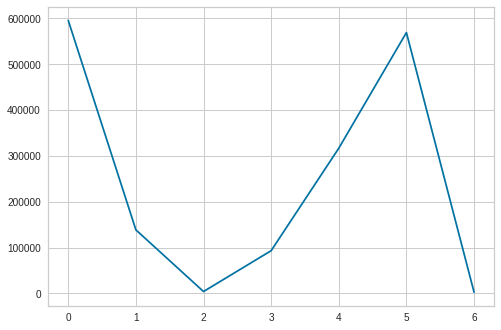

In [179]:
plt.plot(data19.groupby('ageRange')['user_day_code'].count())

In [ ]:
#Calculate KMs 
from numpy import cos, sin, arcsin, sqrt
from math import radians

def haversine(data19):
  lon1 = data19['Longitud_idunplug']
  lat1 = data19['Latitud_idunplug']
  lon2 = data19['Longitud_idplug']
  lat2 = data19['Latitud_idplug']
  lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) #change a radians
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
  c = 2 * arcsin(sqrt(a))
  km = 6367 * c # Tierra es una esfera perfecta de radio RT = 6367
  return km 

In [ ]:
data19['distance'] = data19.apply(lambda data19: haversine(data19), axis=1)

In [ ]:
data19.distance

0          0.671251
1          2.514487
2          2.514487
3          2.514487
4          2.514487
             ...   
1719646    1.213960
1719647    2.607995
1719648    2.129070
1719649    0.511951
1719650    2.989298
Name: distance, Length: 1719651, dtype: float64

In [ ]:
data19.columns

Index(['id_x_x', 'user_day_code', 'idunplug_station', 'Distrito_idunplug',
       'Barrio_idunplug', 'Longitud_idunplug', 'Latitud_idunplug',
       'idplug_station_x', 'Distrito_idplug', 'Barrio_idplug',
       'Longitud_idplug', 'Latitud_idplug', 'user_type_x', 'travel_time_x',
       'unplug_hourTime_x', 'ageRange_x', 'zip_code_x', 'distance'],
      dtype='object')

In [ ]:
data19.groupby(['user_type', 'ageRange']).size()

user_type  ageRange
0          0             8041
1          0           255141
           1             1057
           2             4048
           3            33437
           4           170608
           5           121324
           6             2585
2          0             4077
           2                5
           3               20
           4               55
           5               26
3          0           328254
           1           137533
           3            59709
           4           146080
           5           447651
dtype: int64

In [ ]:
prediction19_1 = data19[['distance']]

In [ ]:
data19.head()

id_x_x  ...  distance
0  5c4b07ea2f38432e007daab8  ...  0.671251
1  5c4b07ec2f38432e007dac38  ...  2.514487
2  5c4b07ec2f38432e007dac38  ...  2.514487
3  5c4b07fc2f38432e007db98d  ...  2.514487
4  5c4b07fc2f38432e007db98d  ...  2.514487

[5 rows x 18 columns]

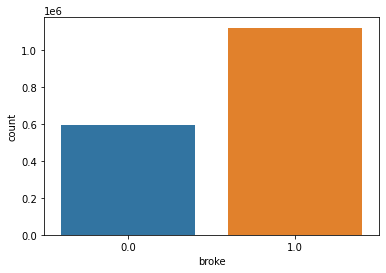

In [ ]:
broke_dict = {3:1, 2:0, 1:0}
data19['broke'] = data19.user_type.map(broke_dict)
data19['broke'].unique()
jan19_broke = sns.countplot(x='broke', data=data19)
jan19_broke

In [ ]:
predictions2 = jan19[['idunplug_station']]

In [ ]:
# predict_2 = reg2.predict(jan18[['idunplug_station']])
predict2 = reg2.predict([predictions2])

NameError: ignored

In [ ]:
jan18['predictions2'] = predict_2

NameError: ignored

In [ ]:
jan18.head()

id  ... predictions2
0  5a505acd2f384319304ed614  ...    76.546165
1  5a505acd2f384319304ed615  ...    79.362496
2  5a505acd2f384319304ed616  ...    79.362496
3  5a505acd2f384319304ed617  ...    88.437343
4  5a505acd2f384319304ed619  ...   102.049613

[5 rows x 13 columns]

In [ ]:
jan18.loc[:, ['idunplug_station','idplug_station']]

idunplug_station  idplug_station
0                      6               7
1                     24             117
2                     24             117
3                     82             110
4                    169              58
...                  ...             ...
263697                99              52
263698                 8              52
263699               135               6
263700               135               6
263701                57              58

[263701 rows x 2 columns]

#### Working with users use the bike with most frequence

In [ ]:
mostfreque_user.head()

c2ffe60f304a285ee6820f3f614a1b898c3cdcdfe3f603c3054d0e8faa332197    196
6ddc03802fd4c3dbb3c6ce0ca5e9117f3a84613e9bdd02bc08bd6e990ed081e0    183
4fa75531c7a69299c7453466339ace1a986864696479356053ac8178ddc288f8    183
21b69baf5bf36a93e5b8898a8bc9bc29a84b34ccbe3d1a87a412f1046783bc4b    182
b550323a7ba2a04fae56749cdf755a6c93479931fa599213d66f3e4d8809160a    179
Name: user_day_code, dtype: int64

In [ ]:
from sklearn.metrics import mean_absolute_error
# Use against predictions
error2 = mean_absolute_error(reg2.predict(X_tr), y_tr)

### Random 

In [ ]:
predictions=jan19[['idunplug_station']].head(263701)
predictions19 = reg.predict(predictions)
jan18['predictions19'] = predictions19

In [ ]:
lm2 = sm.OLS(y_tr, sm.add_constant(X_tr))

In [ ]:
lm_model2 = lm2.fit()
lm_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       idunplug_station   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2494.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        17:08:25   Log-Likelihood:            -1.4080e+06
No. Observations:              263701   AIC:                         2.816e+06
Df Residuals:                  263697   BIC:                         2.816e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             70.1777      0.273    257.484      0.000      69.644      70.712
idplug_station     0.1549      0.002     80.613      0.000       0.151       0.159
user_type          4.5025      0.157     28.730      0.000       4.195       4.810
travel_time     2.768e-05   1.11e-05      2.487      0.013    5.86e-06    4.95e-05
==============================================================================
Omnibus:                   106212.979   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13197.847
Skew:                           0.007   Prob(JB):                         0.00
Kurtosis:                       1.904   Cond. No.                     2.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Conecting into Mobility Lab API


In [ ]:
import requests

In [ ]:
# url = 'https://openapi.emtmadrid.es/v1/transport/bicimad/stations/<idStation>/'
resp = requests.get('https://openapi.emtmadrid.es/v1/transport/bicimad/stations/<idStation>/')
resp.content[:500]

b'{"code": "80", "description": "Error, token none not found in cache", "datetime": "2020-04-11T18:25:37.725984", "data": []}'

In [ ]:
r = requests.get('https://openapi.emtmadrid.es/v1/transport/bicimad/stations/<idStation>/')
r.status_code

200

In [ ]:
r.content

b'{"code": "80", "description": "Error, token none not found in cache", "datetime": "2020-04-11T18:27:46.344736", "data": []}'

In [ ]:
r = requests.get('https://openapi.emtmadrid.es/v1/mobilitylabs/collection/reactive/<idcollection>/<idlinkname>/')

In [ ]:
curl -X POST \


NameError: ignored